In [3]:
import sys
sys.path.append("../")
import settings
from tqdm import tqdm
import json
import os
from process_sentinel2 import Mask, DayDataGenerator, DayData
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def draw_text(text,img, x , y, color = (255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (110, 25)
    fontScale = 1
    thickness = 2
    cv2.putText(img, text, (x, y), font, 1, color, thickness, cv2.LINE_AA)

### Define variables

In [5]:
RAW_DATA_PATH = settings.raw_data_path
PROCESSED_DATA_PATH = settings.processed_data_path
DATE_FORMAT = '%Y-%m-%d'

START_DATE = '2016-01-04'
END_DATE = '2021-03-26'
#END_DATE_NEW = '2022-04-20'

#START_DATE = '2018-11-01'
#END_DATE = '2022-05-01'

MASK_PATH = settings.water_mask_path

TA_coords = [(-34.829637, -55.042053)]

In [6]:
cisne_coords = [(-34.840706,-55.124542),
                (-34.840874,-55.124161),
                (-34.840958,-55.123714),
                (-34.841045,-55.123295),
                (-34.841148,-55.122890),
                (-34.841213,-55.122463),
                (-34.841267,-55.122021),
                (-34.841263,-55.121574),
                (-34.841316,-55.121098),
                (-34.841351,-55.120655),
                (-34.841373,-55.120228),
                (-34.841446,-55.119766),
                (-34.841412,-55.119339),
                (-34.841366,-55.118900),
                (-34.841270,-55.118450),
                (-34.841190,-55.117992),
                (-34.841217,-55.117546),
                (-34.841038,-55.117142),
                (-34.840878,-55.116745),
                (-34.840683,-55.116371),
                (-34.840454,-55.116020),
                (-34.840191,-55.115730),
                (-34.839989,-55.115360),
                (-34.839691,-55.115154),
                (-34.841896,-55.124554),
                (-34.842670,-55.124363),
                (-34.843388,-55.124084),
                (-34.844120,-55.123917),
                (-34.844803,-55.123581),
                (-34.845470,-55.123329),
                (-34.845757,-55.122528),
                (-34.846046,-55.121731),
                (-34.846363,-55.120941),
                (-34.846489,-55.120060),
                (-34.847328,-55.118622),
                (-34.848049,-55.118713),
                (-34.848778,-55.118721),
                (-34.848412,-55.117973),
                (-34.848007,-55.117233),
                (-34.848095,-55.116329),
                (-34.848179,-55.115429),
                (-34.848244,-55.114578),
                (-34.848476,-55.113739),
                (-34.848526,-55.112934),
                (-34.848301,-55.112099),
                (-34.847683,-55.111664),
                (-34.847027,-55.111271),
                (-34.846401,-55.110752),
                (-34.845741,-55.110382),
                (-34.844952,-55.110188),
                (-34.844261,-55.110210),
                (-34.843727,-55.110916),
                (-34.843151,-55.111576)]
print(len(cisne_coords))

53


### Make instance of data generator

In [8]:
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)
len(data_generator)

92

### Load sample day

In [9]:
sample_day = DayData(os.path.join(settings.processed_data_path, "2020-03-23", "MSI"))

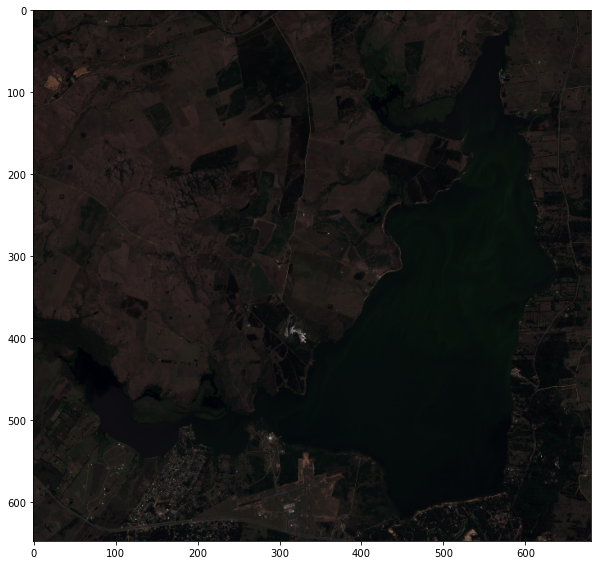

In [10]:
#sample_day.paint_coords(cisne_coords, (255, 255, 0), radius=1)
sample_day.show_rgb()
#plt.savefig("cisnes_sample_points.png", dpi=200, bbox_inches='tight')

### Load water mask

In [11]:
mask = Mask(MASK_PATH)
#mask.reduce_mask()

print("Pixel count:", mask.get_pixel_count())

Pixel count: 2174


### Display mask in sample day

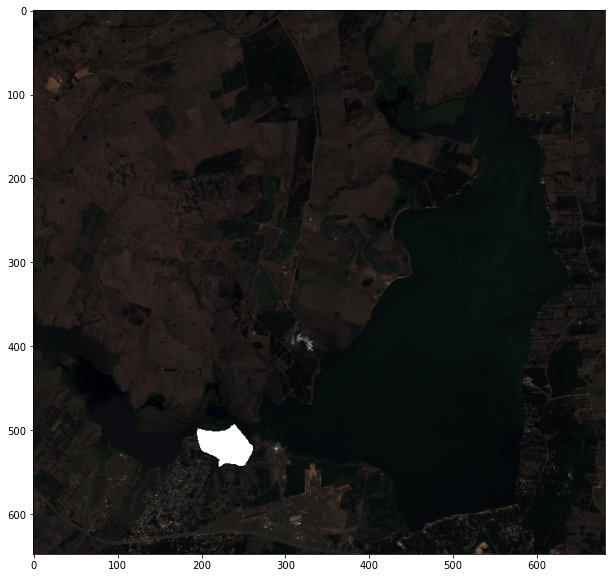

In [12]:
#sample_day = DayData(os.path.join(settings.data_path, "2020-05-30", "acolite_output"))
fig = plt.figure(figsize=(20,10))
#sample_day.paint_coords(cisne_coords, (0, 0, 255), radius=1)
rgb_with_mask = mask.display_mask_img(sample_day.rgb)
plt.imshow(rgb_with_mask)
#plt.savefig("cisnes_with_mask.png", dpi=200, bbox_inches='tight')
plt.show()

### Tag image cloudiness

levels of cloud:

0) Clear

1) minimum clouds over the lake

2) medium amount of clouds

3) too cloudy to be any good


In [15]:
# from IPython.display import clear_output
# import time
# START_DATE = '2018-11-01'
# END_DATE = '2022-05-01'
# data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, tagging=True)
# retag = False

# for day in data_generator:
#     print(day.date)
#     print(day.metadata)
#     current_metadata = day.metadata
#     if current_metadata != {} and not retag:
#         time.sleep(0.1)
#         clear_output(wait=True)
#         continue
#     # display rgb of day
#     fig = plt.figure(figsize=(20,10))
#     plt.imshow(mask.display_mask_contour(day.rgb))
#     plt.show()
#     # get user input
#     user_input = input()
#     # overwrite with changes
#     with open(day.metadata_path, 'w') as fp:
#         current_metadata["cloud level"] = user_input
#         json.dump(current_metadata, fp)
#     clear_output(wait=True)

2022-04-12 13:32:31-03:00
{'cloud level': '2'}


### Acquisition metrics

In [8]:
data_generator_all = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=False)
data_generator_valid = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)

print(f"Total dates: {len(data_generator_all)}")
print(f"Valid dates: {len(data_generator_valid)}")

Total dates: 315
Valid dates: 101


## Clustering

### Make NDCI numpy array dataset

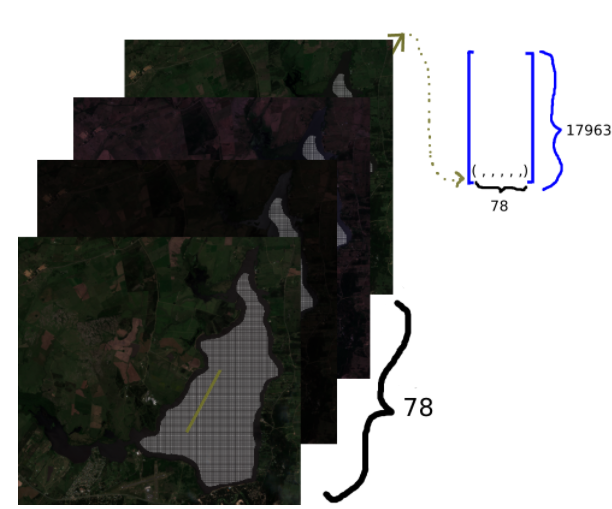

In [23]:
# make instance of data generator that skips invalid dates
data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)
# make array to store ndci of every valid day
ndci_dataset_array = np.zeros((sample_day.rgb.shape[0], sample_day.rgb.shape[1], len(data_generator)))
H, W, D = ndci_dataset_array.shape
# list of dates for ndci_dataset_array
dates_list = []
# progress bar
pbar = tqdm(total=len(data_generator))
for d, day in enumerate(data_generator):
    ndci_day_array = day.get_NDCI()
    dates_list.append(str(day.date.date()))
    ndci_dataset_array[:, :, d] = ndci_day_array
    pbar.update(1)
pbar.close()

100%|██████████| 101/101 [00:13<00:00,  7.61it/s]


### Make clustering dataset

In [24]:
clustering_dataset = []
indexes = []
pbar = tqdm(total=mask.height*mask.width)
for i in range(mask.height):
    for j in range(mask.width):
        if mask.array[i, j] == 1:
            clustering_dataset.append(list(ndci_dataset_array[i, j, :]))
            indexes.append([i, j])
        pbar.update(1)
pbar.close()
clustering_data = {}
clustering_data["data"] = clustering_dataset
clustering_data["positions"] = indexes
clustering_data["dates"] = dates_list

100%|██████████| 441288/441288 [00:00<00:00, 629015.18it/s]


### Save to json

In [9]:
# with open("clustering_dataset_20m.json", 'w') as f:
#     json.dump(json_dictionary, f)

### Load clustering dataset

In [10]:
# import json

# with open("clustering_dataset_20m.json") as f:
#     clustering_data = json.load(f)

# Fit clustering data

In [33]:
X = np.array(clustering_data["data"])

### K-means

100%|██████████| 6/6 [00:08<00:00,  1.42s/it]

[282.5752652813624, 236.19423455157025, 214.29500119110037, 202.44081979183287, 192.47995512411785, 184.94552033790106]


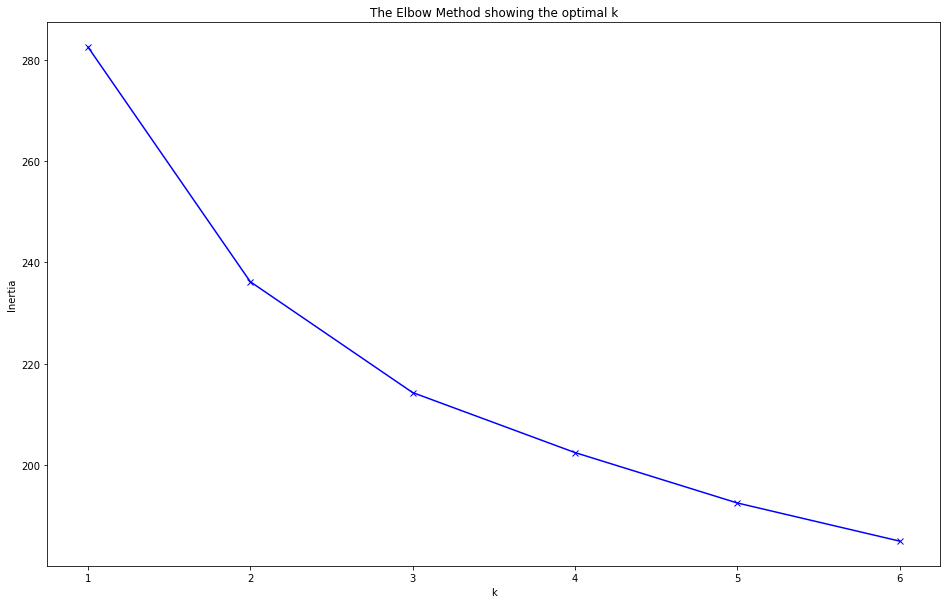

In [34]:
from sklearn.cluster import KMeans


kmeans_save_path = "K-means"
    
inertias = []
K = range(1,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=len(K))
for k in K:
    clustering = KMeans(n_clusters=k)
    clustering.fit(X)
    inertias.append(clustering.inertia_)
    
    sample_day = DayData(os.path.join(settings.processed_data_path, "2021-01-25", "MSI"))
    unique_labels = list(set(clustering.labels_))
                
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters.png")
    #fig = plt.figure(figsize=(20,20))
    #plt.imshow(final_img)
    #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    #plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    #timeseries_image_path = os.path.join(kmeans_save_path, str(k) + "_clusters_timeseries.png")
    #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()
print(inertias)

inertias_image_path = os.path.join(kmeans_save_path, "inertias.png")
plt.figure(figsize=(16,10))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
#plt.savefig(inertias_image_path, dpi=100, bbox_inches='tight')
plt.show()

### Agglomerative clustering

In [14]:
linkage_methods = ["single", "complete", "average", "ward"]

metrics = ["euclidean", "cityblock", "cosine"]

Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used.

In [66]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

output_directory = "Agglomerative_clustering"
save_matrix = True
overwrite = False

sample_day = DayData(os.path.join("sample_data", "2021-01-25"))

clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]

H, W, D = ndci_dataset_array.shape

for linkage_method in linkage_methods:
    for distance_metric in metrics:
        if linkage_method == "ward" and distance_metric != "euclidean":
            continue
        print("processing " + linkage_method + " linkage method with " + distance_metric + " metric")
        #create directory if doesn't exist already
        agglomerative_clustering_directory = os.path.join(output_directory, linkage_method, distance_metric)
        if not os.path.isdir(agglomerative_clustering_directory):
            os.makedirs(agglomerative_clustering_directory)
            
            # make linkage matrix or load if already stored
            try:
                linkage_matrix = np.load(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"))

            except FileNotFoundError:
                linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)
                if save_matrix == True:
                    np.save(os.path.join(agglomerative_clustering_directory, "linkage_matrix.npy"), linkage_matrix)

            # make and save dendogram
            fig = plt.figure(figsize=(20,13))
            dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
            plt.title(linkage_method + ' linkage dendrogram')
            plt.xlabel('Number of points in node')
            plt.ylabel(distance_metric + ' distances')
            #plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
            plt.close(fig)
            #plt.show()
            
            # process dataset for different amount of clusters and store things
            for n_clusters in [3, 4, 5, 6]:
                clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity=distance_metric, linkage=linkage_method).fit(X)
                unique_labels = list(set(clustering.labels_))
                
                #image without clusters
                final_img = sample_day.rgb.copy()
                labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
                # itearte over a list containing the label of every pixel in the lagoon and paint it on map
                for i, label in enumerate(clustering.labels_):
                    if label == -1:
                        continue
                    label_position = clustering_data["positions"][i]
                    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
                    labels_arr[label_position[0], label_position[1]] = int(label)
                    
                #draw legends
                legend_position = {"x": 50, "y": 50}
                for label in unique_labels:
                    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
                    legend_position["y"] = legend_position["y"] + 50    

                # make and save map with clusters
                clusters_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters.png")
                fig = plt.figure(figsize=(20,10))
                plt.imshow(final_img)
                #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
                plt.close(fig)
                    
                #get NDCI mean and std of every cluster in every day
                results = []
                for d in range(D):
                    day_results = {}
                    day_results["date"] = clustering_data["dates"][d]
                    day_ndci = ndci_dataset_array[:, :, d]

                    for label in unique_labels:
                        y, x = np.where(labels_arr == label)
                        label_ndci_values = []
                        for i, j in zip(y, x):
                            label_ndci_values.append(day_ndci[i, j])
                        label_ndci_values = np.array(label_ndci_values)
                        label_mean = np.mean(label_ndci_values)
                        label_std = np.std(label_ndci_values)

                        day_results[label] = {"mean": label_mean, "std": label_std}
                    results.append(day_results)

                # make and save image with cluster mean time series
                day_indexes = range(1, len(results)+1)
                fig = plt.figure(figsize=(40,20))
                for label in unique_labels:
                    label_means = [d[label]["mean"] for d in results]
                    #label_stds = [d[label]["std"] for d in results]
                    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
                    color = tuple([c/255 for c in clusters_colors[label]])
                    plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
                    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
                    
                plt.xlabel('date')
                plt.xticks(np.arange(1, len(results)+1, 1.0))
                # Set the y axis label of the current axis.
                plt.ylabel('cluster NDCI mean')
                # Set a title of the current axes.
                plt.title('Time series of NDCI mean for every cluster')
                # put date in angle to read better
                fig.autofmt_xdate()
                # show a legend on the plot
                plt.legend(prop={'size': 40})
                # save figure
                timeseries_image_path = os.path.join(agglomerative_clustering_directory, str(n_clusters) + "_clusters_timeseries")
                #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
                plt.close(fig)

processing ward linkage method with euclidean metric
processing complete linkage method with euclidean metric
processing complete linkage method with cityblock metric
processing complete linkage method with cosine metric
processing single linkage method with euclidean metric
processing single linkage method with cityblock metric
processing single linkage method with cosine metric
processing average linkage method with euclidean metric
processing average linkage method with cityblock metric
processing average linkage method with cosine metric


### Spectral

In [64]:
from sklearn.cluster import SpectralClustering

spectral_save_path = "Spectral"

K = range(3,7)
clusters_colors = [[240, 15, 15], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [255,255,255]]
pbar = tqdm(total=7)
for k in K:
    clustering = SpectralClustering(n_clusters=k)
    clustering.fit(X)
    
    sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
    unique_labels = list(set(clustering.labels_))
    
    # load image without clusters
    final_img = sample_day.rgb.copy()
    labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254
    # itearte over a list containing the label of every pixel in the lagoon and paint it on map
    for i, label in enumerate(clustering.labels_):
        if label == -1:
            continue
        label_position = clustering_data["positions"][i]
        final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
        labels_arr[label_position[0], label_position[1]] = int(label)

    #draw legends
    legend_position = {"x": 50, "y": 50}
    for label in unique_labels:
        draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
        legend_position["y"] = legend_position["y"] + 50    

    # make and save map with clusters
    clusters_image_path = os.path.join(spectral_save_path, str(k) + "_clusters.png")
    fig = plt.figure(figsize=(20,20))
    plt.imshow(final_img)
    #plt.savefig(clusters_image_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

    #get NDCI mean and std of every cluster in every day
    results = []
    for d in range(D):
        day_results = {}
        day_results["date"] = clustering_data["dates"][d]
        day_ndci = ndci_dataset_array[:, :, d]

        for label in unique_labels:
            y, x = np.where(labels_arr == label)
            label_ndci_values = []
            for i, j in zip(y, x):
                label_ndci_values.append(day_ndci[i, j])
            label_ndci_values = np.array(label_ndci_values)
            label_mean = np.mean(label_ndci_values)
            label_std = np.std(label_ndci_values)

            day_results[label] = {"mean": label_mean, "std": label_std}
        results.append(day_results)

    # make and save image with cluster mean time series
    day_indexes = range(1, len(results)+1)
    fig = plt.figure(figsize=(40,20))
    for i, label in enumerate(unique_labels):
        label_means = [d[label]["mean"] for d in results]
        #label_stds = [d[label]["std"] for d in results]
        #plt.plot(day_indexes, label_means, label=str(label) + " mean")
        color = tuple([c/255 for c in clusters_colors[label]])
        plt.plot([d["date"] for d in results], label_means, label=str(label), color=color)
        #plt.plot(day_indexes, label_stds, label=str(label) + " std")

    plt.xlabel('date')
    plt.xticks(np.arange(0, len(results), 1.0))
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean')
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for every cluster')
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(prop={'size': 40})
    # save figure
    timeseries_image_path = os.path.join(spectral_save_path, str(k) + "_clusters_timeseries.png")
    #plt.savefig(timeseries_image_path, dpi=100, bbox_inches='tight')
    plt.close(fig)

    
    pbar.update(1)
pbar.close()

 57%|█████▋    | 4/7 [13:32<10:09, 203.09s/it]


### Choose clustering algorithm

In [45]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS

#sample_date_idx = dates_list.index('2020-03-23')
sample_date_idx = dates_list.index('2021-04-12')

clustering = KMeans(n_clusters=4, random_state=42).fit(X[:, :sample_date_idx])
#clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward').fit(X)
#clustering = SpectralClustering(n_clusters=3, assign_labels='discretize').fit(X)
#clustering = OPTICS(min_samples=100).fit(X)

### Display dendogram

In [ ]:
linkage_methods = ["ward", "complete", "single", "average"]
distance_metrics = ["euclidean", "cityblock", "cosine"]

linkage_method = linkage_methods[1]
distance_metric = distance_metrics[1]
linkage_matrix = sch.linkage(X, method=linkage_method, metric=distance_metric)

# make and save dendogram
fig = plt.figure(figsize=(20,13))
dendrogram = sch.dendrogram(linkage_matrix, truncate_mode='level', p=3)
plt.title(linkage_method + ' linkage dendrogram')
plt.xlabel('Number of points in node')
plt.ylabel(distance_metric + ' distances')
#plt.savefig(os.path.join(agglomerative_clustering_directory, "dendogram.jpg"))
#plt.close(fig)
plt.show()

### Display clusters

cluster labels: [0, 1, 2, 3]


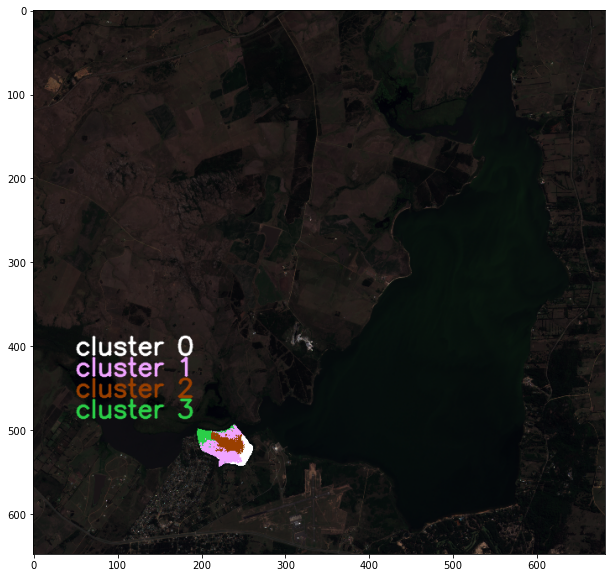

In [46]:
from process_sentinel2 import *
import random
import cv2

#sample_day = DayData(os.path.join("sample_data", "2021-01-25"))
sample_day = DayData(os.path.join(settings.processed_data_path, "2020-03-23", "MSI"))
#sample_day.show_rgb()
final_img = sample_day.rgb.copy()
labels_arr = np.ones((final_img.shape[0], final_img.shape[1]), dtype=np.uint8)*254


clusters_colors = [[255,255,255], [240,163,255], [153,63,0], [43,206,72], [255,204,153], [31, 49, 209], [0, 0, 0]]

unique_labels = list(set(clustering.labels_))
print("cluster labels:", unique_labels)

# here I'm iterating over a list containing the label of every pixel in the lagoon
for i, label in enumerate(clustering.labels_):
    if label == -1:
        continue
    label_position = clustering_data["positions"][i]
    final_img[label_position[0], label_position[1], :] = clusters_colors[label]    
    labels_arr[label_position[0], label_position[1]] = int(label)

#draw legends
legend_position = {"x": 50, "y": 410}
for label in unique_labels:
    draw_text("cluster " + str(label), final_img, legend_position["x"], legend_position["y"], color=clusters_colors[label])
    legend_position["y"] = legend_position["y"] + 25    

fig = plt.figure(figsize=(20,10))
plt.imshow(final_img)
#plt.savefig("prediction_data/kmeans_3/kmeans_3.png")
plt.show()

### Paint coords on top of clusters

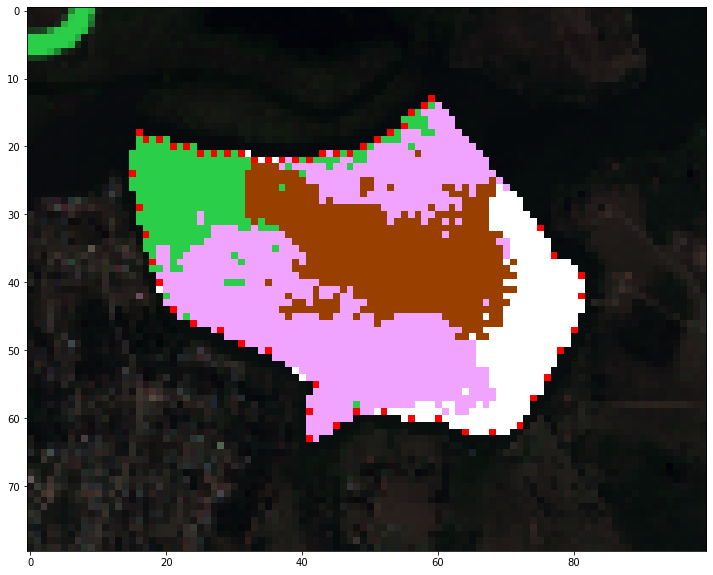

In [47]:
sample_day.rgb = final_img 
sample_day.paint_coords(cisne_coords, (255, 0, 0), radius=0)
#draw_text("Water samples", sample_day.rgb, 50, 600, color=(255, 0, 0))
fig = plt.figure(figsize=(20,10))
plt.imshow(final_img[480:560, 180:280,:])
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

### Make pandas dataframe with mean and std of every cluster for every day

In [51]:
H, W, D = ndci_dataset_array.shape

results = []

pbar = tqdm(total=D)
for d in range(D):
    day_ndci = ndci_dataset_array[:, :, d]
#     day_results = {}
#     day_results["date"] = clustering_data["dates"][d]
    for label in unique_labels:
        day_results = {}
        #day_results["date"] = clustering_data["dates"][d]
        day_results["date"] = datetime.strptime(clustering_data["dates"][d], "%Y-%m-%d")
        y, x = np.where(labels_arr == label)
        label_ndci_values = []
        for i, j in zip(y, x):
            label_ndci_values.append(day_ndci[i, j])
        label_ndci_values = np.array(label_ndci_values)
        label_mean = np.mean(label_ndci_values)
        label_std = np.std(label_ndci_values)
        
        #day_results[label] = {"mean": label_mean, "std": label_std}
        day_results["mean_ndci"] = label_mean
        day_results["max_ndci"] = label_mean + 2*label_std
        day_results["min_ndci"] = label_mean - 2*label_std
        day_results["cluster"] = label
        results.append(day_results)
    pbar.update(1)            
pbar.close()

results_df = pd.DataFrame(results)
#results_df.to_csv("../../data/final/kmeans_3/ndci_data.csv", index=False)
results_df

100%|██████████| 101/101 [00:00<00:00, 223.54it/s]


date  mean_ndci  max_ndci  min_ndci  cluster
0   2018-11-04  -0.049984 -0.021715 -0.078254        0
1   2018-11-04  -0.053506 -0.029102 -0.077909        1
2   2018-11-04  -0.056602 -0.034451 -0.078753        2
3   2018-11-04  -0.054708 -0.025811 -0.083604        3
4   2018-11-09  -0.057191 -0.023323 -0.091059        0
..         ...        ...       ...       ...      ...
399 2022-04-05   0.004962  0.029703 -0.019779        3
400 2022-04-10  -0.010584  0.086076 -0.107244        0
401 2022-04-10  -0.008082  0.083799 -0.099962        1
402 2022-04-10  -0.014797  0.014293 -0.043886        2
403 2022-04-10  -0.008439  0.016711 -0.033588        3

[404 rows x 5 columns]

## NDCI clusters validation

### Cisnes

In [52]:
atm_correction_gt_path = "../../data/final/2020-03-23/Laguna_Sauce_23-03-2020.csv"
CHL_TH = 10
gt_date = "2020-03-23"

atm_correction_gt_df_base = pd.read_csv(atm_correction_gt_path, index_col=False)
data_reformatted = []
measures = atm_correction_gt_df_base["measure"].values.tolist()
locations = atm_correction_gt_df_base.columns.tolist()[1:]
for location_name in atm_correction_gt_df_base.columns.tolist()[1:]:
    location_data_dict = {}
    for i, measure in enumerate(measures):
        location_data_dict[measure] = atm_correction_gt_df_base[location_name][i]
    location_data_dict["location"] = location_name
    data_reformatted.append(location_data_dict)
atm_correction_gt_df = pd.DataFrame(data_reformatted)
atm_correction_gt_df = atm_correction_gt_df[["Total chlorophyll concentration", "lat", "lon", "location"]]
atm_correction_gt_df = atm_correction_gt_df[atm_correction_gt_df["Total chlorophyll concentration"] > CHL_TH]

atm_correction_gt_df

Total chlorophyll concentration        lat        lon  location
0                             51.86 -34.841896 -55.124554     Sur 1
1                             54.91 -34.842670 -55.124363     Sur 2
2                             61.18 -34.843380 -55.123917     Sur 3
3                             64.12 -34.844120 -55.123917     Sur 4
4                             67.64 -34.844803 -55.123581     Sur 5
5                             74.78 -34.845470 -55.123329     Sur 6
7                             66.85 -34.846363 -55.120941     Sur 8
8                             61.59 -34.846363 -55.120941     Sur 9
9                             62.75 -34.846489 -55.120060    Sur 10
12                            75.28 -34.848778 -55.118721    Sur 13
13                            67.69 -34.848412 -55.117973    Sur 14
14                            66.98 -34.848007 -55.117233    Sur 15
15                            69.11 -34.848095 -55.116329    Sur 16
16                            73.88 -34.848179 -55.115429    Sur 17
17                            75.55 -34.848244 -55.114578    Sur 18
18                            66.37 -34.848476 -55.113739    Sur 19
19                            72.31 -34.848526 -55.112934    Sur 20
20                            70.01 -34.848301 -55.112099    Sur 21
21                            73.94 -34.847683 -55.111664    Sur 22
22                            69.19 -34.847027 -55.111271    Sur 23
23                            68.26 -34.846401 -55.110752    Sur 24
24                            67.44 -34.845741 -55.110382    Sur 25
25                            66.91 -34.844952 -55.110188    Sur 26
26                            72.80 -34.844261 -55.110210    Sur 27
27                            63.31 -34.843727 -55.110916    Sur 28
28                            69.59 -34.843151 -55.111576    Sur 29
29                            55.91 -34.840706 -55.124542   Norte 1
30                            75.55 -34.840874 -55.124161   Norte 2
31                            58.98 -34.840958 -55.123714   Norte 3
32                            59.26 -34.841045 -55.123295   Norte 4
33                            56.51 -34.841148 -55.122890   Norte 5
34                            56.41 -34.841213 -55.122463   Norte 6
35                            56.04 -34.841267 -55.122021   Norte 7
36                            56.77 -34.841263 -55.121574   Norte 8
37                            54.33 -34.841316 -55.121098   Norte 9
39                            57.57 -34.841373 -55.120228  Norte 11
40                            53.35 -34.841446 -55.119766  Norte 12
41                            55.05 -34.841412 -55.119339  Norte 13
42                            57.49 -34.841366 -55.118900  Norte 14
43                            58.65 -34.841270 -55.118450  Norte 15
44                            52.87 -34.841190 -55.117993  Norte 16
45                            55.37 -34.841217 -55.117546  Norte 17
46                            44.85 -34.841038 -55.117142  Norte 18
47                            44.27 -34.840878 -55.116745  Norte 19
48                            44.94 -34.840683 -55.116371  Norte 20
49                            41.72 -34.840454 -55.116020  Norte 21
50                            37.37 -34.840191 -55.115730  Norte 22
51                            34.96 -34.839989 -55.115360  Norte 23
52                            37.83 -34.839691 -55.115154  Norte 24

100%|██████████| 441288/441288 [00:01<00:00, 303859.10it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



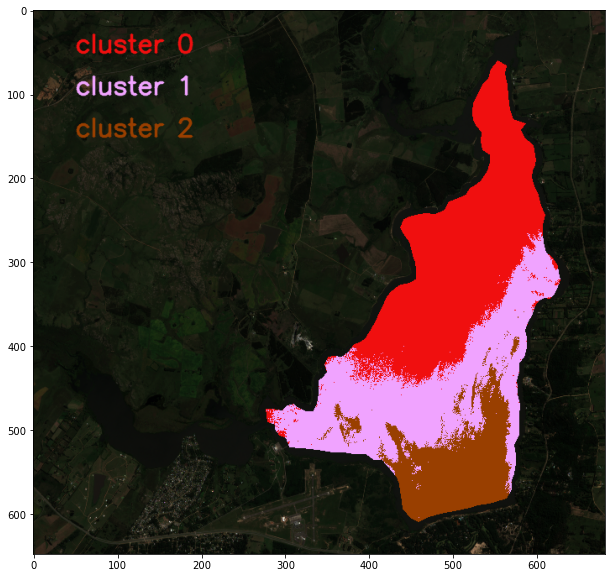

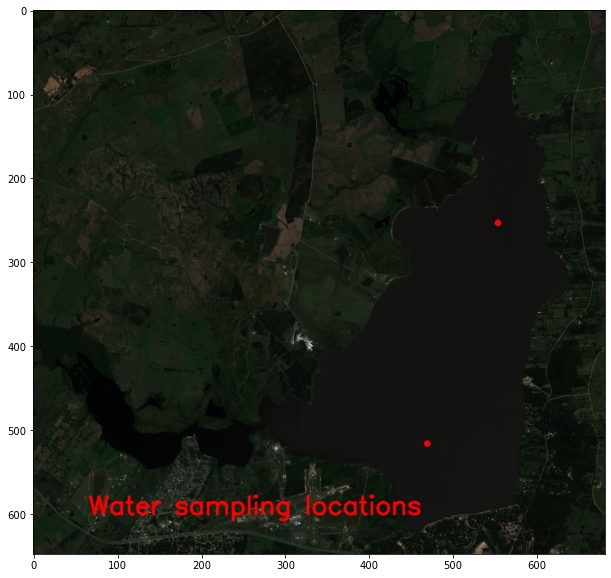

In [73]:
from clustering import ClusteringProcessing

sampling_points_coords = {
                              "SAUCE NORTE": [-34.795398, -55.047355],
                              "SAUCE SUR": [-34.843127, -55.064624]
                         }

num_clusters = 3

day_data_generator = DayDataGenerator(START_DATE, END_DATE, DATE_FORMAT, PROCESSED_DATA_PATH, skip_invalid=True)
mask = Mask(MASK_PATH)
clustering_object = ClusteringProcessing(day_data_generator, mask, clustering_algorithm="kmeans", k_clusters=num_clusters)
clusters_mask = clustering_object.make_clusters_mask()
clusters_image = clustering_object.make_clusters_image()
clustering_ndci_dataset = clustering_object.make_predictions_dataset()
ndci_array = clustering_object.ndci_dataset_array

fig = plt.figure(figsize=(20,10))
plt.imshow(clusters_image)
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

sample_day = DayData(os.path.join(settings.processed_data_path, "2021-02-26", "MSI"))
sample_day.paint_coords([coord for location, coord in sampling_points_coords.items()], (255, 0, 0), radius=4)
draw_text(" Water sampling locations", sample_day.rgb, 50, 600, color=(255, 0, 0))
fig = plt.figure(figsize=(20,10))
plt.imshow(sample_day.rgb)
#plt.savefig("clusters_and_samples.png", dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()

In [74]:
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")

algae_df = pd.read_csv(algae_gt_path)
algae_df["date"] = pd.to_datetime(algae_df["date"])
algae_df["date"] = algae_df["date"].dt.date

algae_df

date      location     fico    chl     label
0    2015-12-30   MALLORQUINA  5032.50  10.00  No Bloom
1    2015-12-30  ARROYO SAUCE  5345.50  21.80  No Bloom
2    2015-12-30   SAUCE NORTE  4282.50   7.50  No Bloom
3    2015-12-30     SAUCE SUR  5388.00   7.50  No Bloom
4    2015-12-30        CISNES  9082.50  18.45     Bloom
..          ...           ...      ...    ...       ...
685  2020-10-31            TA  1083.00    NaN  No Bloom
686  2020-11-01            TA    47.00    NaN  No Bloom
687  2020-11-02            TA     5.96    NaN  No Bloom
688  2020-11-05            TA     9.06    NaN  No Bloom
689  2021-02-04            TA     1.77    NaN  No Bloom

[690 rows x 5 columns]

In [75]:
clustering_ndci_dataset

date  cluster_0_mean  cluster_0_max  cluster_0_min  cluster_1_mean  \
0    2018-11-04       -0.056637      -0.032639      -0.080636       -0.059639   
1    2018-11-09       -0.066890      -0.041914      -0.091866       -0.064845   
2    2018-11-19       -0.032362      -0.006475      -0.058249       -0.035580   
3    2018-11-22       -0.039031      -0.019804      -0.058259       -0.038868   
4    2018-12-12        0.012343       0.032172      -0.007487        0.006067   
..          ...             ...            ...            ...             ...   
96   2022-03-16       -0.030186       0.004435      -0.064806       -0.033092   
97   2022-03-28       -0.032437      -0.005036      -0.059837       -0.037221   
98   2022-04-02       -0.016048       0.011102      -0.043199       -0.023098   
99   2022-04-05       -0.017943       0.005284      -0.041170       -0.018308   
100  2022-04-10       -0.018073       0.017709      -0.053855       -0.029680   

     cluster_1_max  cluster_1_min  cluster_2_mean  cluster_2_max  \
0        -0.037160      -0.082118       -0.060550      -0.038958   
1        -0.040247      -0.089443       -0.060789      -0.033630   
2        -0.009481      -0.061679       -0.033356      -0.008363   
3        -0.020585      -0.057152       -0.038391      -0.018352   
4         0.025000      -0.012866        0.007279       0.028766   
..             ...            ...             ...            ...   
96       -0.005698      -0.060485       -0.041284      -0.016373   
97       -0.012166      -0.062276       -0.038929      -0.014569   
98        0.001873      -0.048069       -0.026206      -0.001786   
99        0.006623      -0.043240       -0.021912       0.001395   
100       0.005550      -0.064910       -0.040366      -0.012169   

     cluster_2_min  
0        -0.082142  
1        -0.087947  
2        -0.058349  
3        -0.058430  
4        -0.014209  
..             ...  
96       -0.066194  
97       -0.063289  
98       -0.050625  
99       -0.045219  
100      -0.068563  

[101 rows x 10 columns]

### Calculate  clusters correlations

In [1]:
sampling_points_idxs = {location: sample_day.get_pos_index(coord[0], coord[1]) for location, coord in sampling_points_coords.items()}
print(sampling_points_idxs)
sampling_points_clusters = {location: clusters_mask[idxs[0], idxs[1]]  for location, idxs in sampling_points_idxs.items()}

merged_data = pd.DataFrame()
for a in ["mean", "min", "max"]:
    print(a)
    for location, cluster in sampling_points_clusters.items():
        print(f"{location}: cluster {cluster}")

        clusters_dates = clustering_ndci_dataset.date.unique().tolist()
        cluster_data = clustering_ndci_dataset[["date", f"cluster_{int(cluster)}_{a}"]]

        location_chl_gt = algae_df[algae_df["location"] == location]

        m = cluster_data.merge(location_chl_gt, on="date", how='inner')
        correlation = m[f'cluster_{int(cluster)}_{a}'].corr(m['chl'])
        print(f"Correlation: {round(correlation, 3)}")
        
        print("---------")
    print("////////////")

NameError: name 'sampling_points_coords' is not defined

### Calculate correlation of NDCI in sampling location

In [117]:
from scipy.stats.stats import pearsonr

for location, idxs in sampling_points_idxs.items():    
    location_chl_gt = algae_df[algae_df["location"] == location]
    location_chl_gt.sort_values(by="date", inplace=True)
    
    common_dates = list(set(location_chl_gt.date.unique().tolist()) & set(clustering_object.dataset["dates"]))
    common_dates.sort()
    location_chl_gt = location_chl_gt[location_chl_gt["date"].isin(common_dates)]
    dates_idxs = [clustering_object.dataset["dates"].index(d) for d in common_dates]
    
    ndcis = [ndci_array[idxs[0], idxs[1], d_idx] for d_idx in dates_idxs]
    chls = location_chl_gt["chl"].tolist()
    
    print(location)
    correlation = pearsonr(ndcis, chls)[0]
    print(f"Correlation: {round(correlation, 3)}")

SAUCE NORTE
Correlation: 0.29
SAUCE SUR
Correlation: 0.069


/home/enzo/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Visualization

### Load data from https://www.ambiente.gub.uy/oan/datos-abiertos/calidad-agua/

In [35]:
import csv

def load_cyano_concentration_csv(csv_path):
    agua_data = []
    with open(csv_path, newline='\n') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(spamreader):
            day_measure = {} 
            if i==0:
                continue
            date_time = datetime.strptime(row[0][0:10], "%Y-%m-%d")
            day_measure["date"] = date_time
            
            cyano_value = row[2]
            day_measure["cyanobacteria"] = float(cyano_value)
            agua_data.append(day_measure)
    output = pd.DataFrame(agua_data)
    return output

agua_data = load_cyano_concentration_csv("../../data/final/agua_open_data(1).csv")
print(agua_data)

          date  cyanobacteria
0   2020-01-02        1150.00
1   2020-01-04       20731.00
2   2020-01-05       17521.00
3   2020-01-06        9943.00
4   2020-01-07       10401.00
..         ...            ...
162 2020-10-31        1083.00
163 2020-11-01          47.00
164 2020-11-02           5.96
165 2020-11-05           9.06
166 2021-02-04           1.77

[167 rows x 2 columns]


### Load data from Cisne measures and reformat it to:

| total chl | lat        | lon       | location |
|----------|------------|-----------|---------------|
| 54       | -34.842145 | -55.64641 | Sur 1         |

In [19]:
chl_th = 10
cisne_df_base = pd.read_csv('Laguna_Sauce_24-03-2020.csv', index_col=False)
data_reformatted = []
measures = cisne_df_base["measure"].values.tolist()
locations = cisne_df_base.columns.tolist()[1:]
for location_name in cisne_df_base.columns.tolist()[1:]:
    location_data_dict = {}
    for i, measure in enumerate(measures):
        location_data_dict[measure] = cisne_df_base[location_name][i]
    location_data_dict["location"] = location_name
    data_reformatted.append(location_data_dict)
cisne_df = pd.DataFrame(data_reformatted)
cisne_df = cisne_df[["Total chlorophyll concentration", "lat", "lon", "location"]]
cisne_df = cisne_df[cisne_df["Total chlorophyll concentration"] > chl_th]

### Get correlations

100%|██████████| 49/49 [04:07<00:00,  5.04s/it]


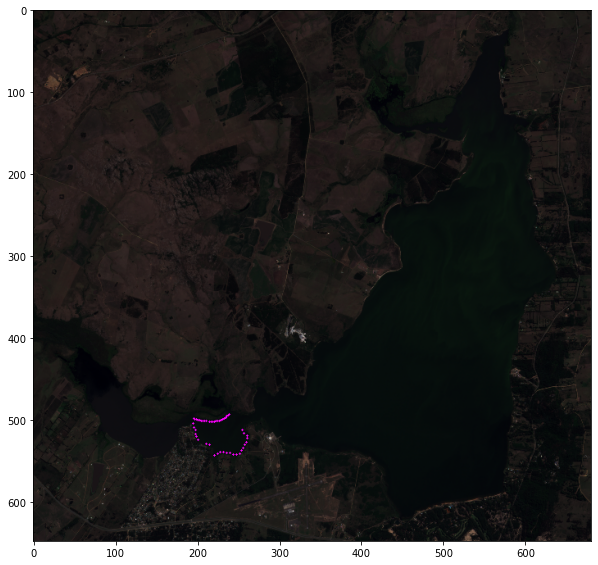

<Figure size 432x288 with 0 Axes>

In [46]:
import random

day_date = "2020-03-23"
day_data = DayData(os.path.join(settings.data_path, day_date, "acolite_output"))
date_index = clustering_data["dates"].index("2020-03-23")
locations = []
gts = []
predicted = []
predicted_ndci = []
pbar = tqdm(total=len(cisne_df))
for index, row in cisne_df.iterrows():
    gt_chl = row["Total chlorophyll concentration"]
    
    lat = row["lat"]
    lon = row["lon"]
    location = row["location"]
    
    location_y, location_x = day_data.get_pos_index(lat, lon)
    
    cluster = cluster_map[location_y, location_x]
    while cluster == 80:
        offsets = [0, 1, -1]
        cluster = cluster_map[location_y + random.choice(offsets), location_x + random.choice(offsets)]
    try:
        cluster_mean = results_df[(results_df["date"] == "2020-03-23") & (results_df["cluster"] == cluster)]["mean_ndci"].values[0]
    except:
        pbar.update(1)
        continue
    day_data.rgb = cv2.circle(day_data.rgb, (location_x, location_y), 1, [255, 0, 255], -1)
    point_ndci = ndci_dataset_array[location_y, location_x, date_index]
    predicted_ndci.append(point_ndci)
    predicted.append(cluster_mean)
    gts.append(gt_chl)
    locations.append(location)
    pbar.update(1)
pbar.close()
day_data.show_rgb()

/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


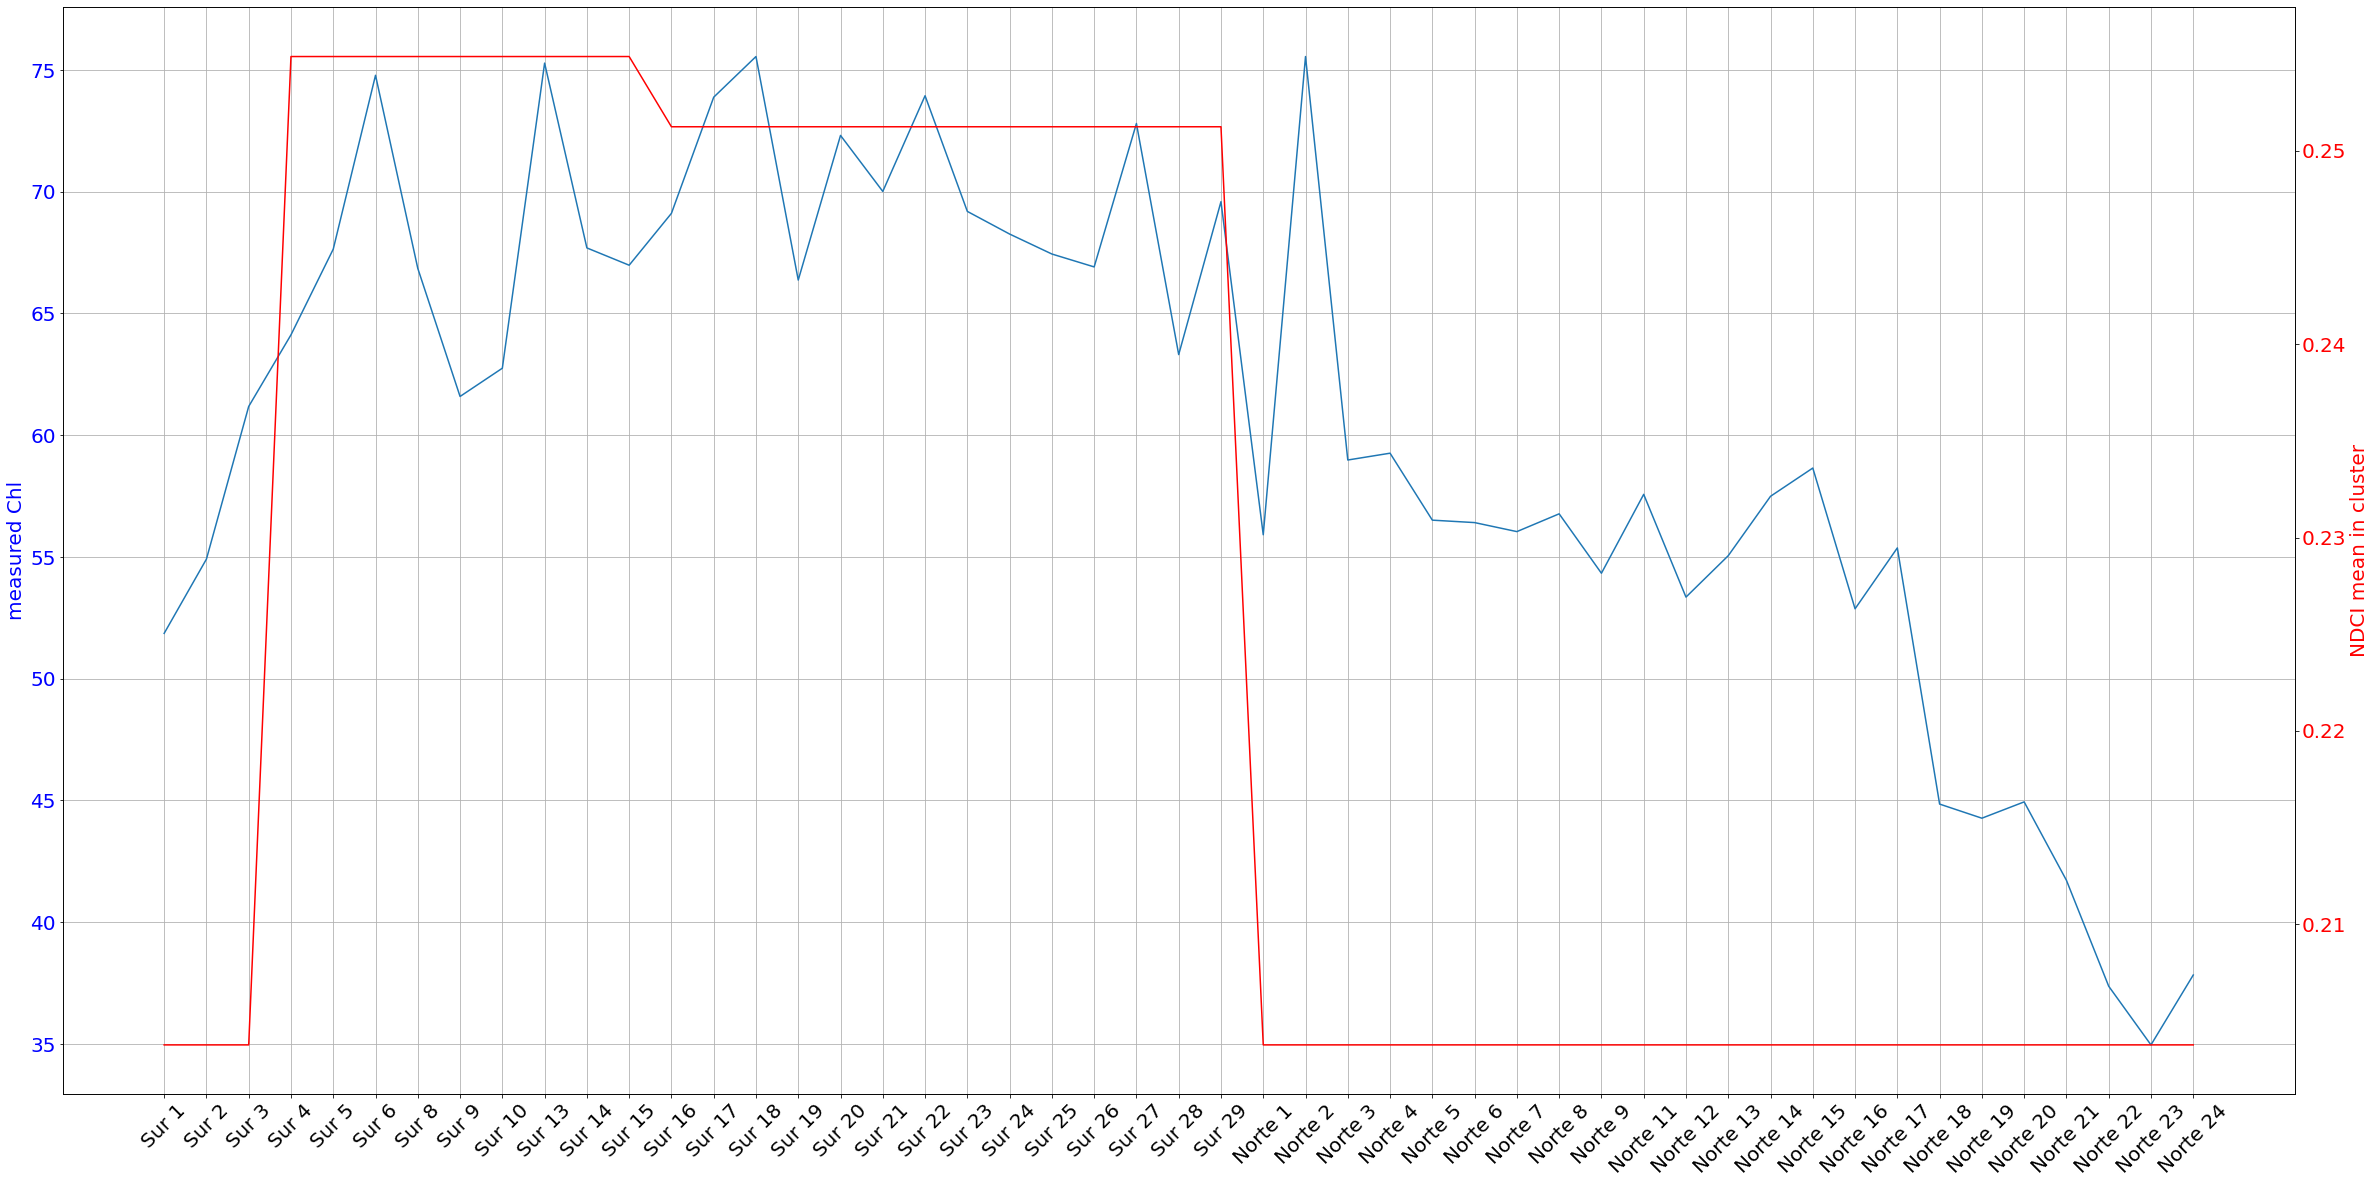

(0.7569281904429389, 3.123393498006782e-10)
(0.7523839348533311, 4.5674585410624923e-10)


In [44]:
fig = plt.figure(figsize=(40,20))
plt.grid()
ax1 = fig.add_subplot(111)
plt.yticks(fontsize=20)
ax1.plot(locations, gts)
ax1.set_ylabel('measured Chl', fontsize=20, color="b")
plt.xticks(fontsize=20, rotation=45)
ax2 = ax1.twinx()
plt.yticks(fontsize=20)
ax2.plot(locations, predicted, 'r-')
ax2.set_ylabel('NDCI mean in cluster', color='r', fontsize=20)
for tl in ax2.get_yticklabels():
    tl.set_color('r')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.show()
print(pearsonr(predicted, gts))
print(pearsonr(predicted_ndci, gts))

### Time series of NDCI mean

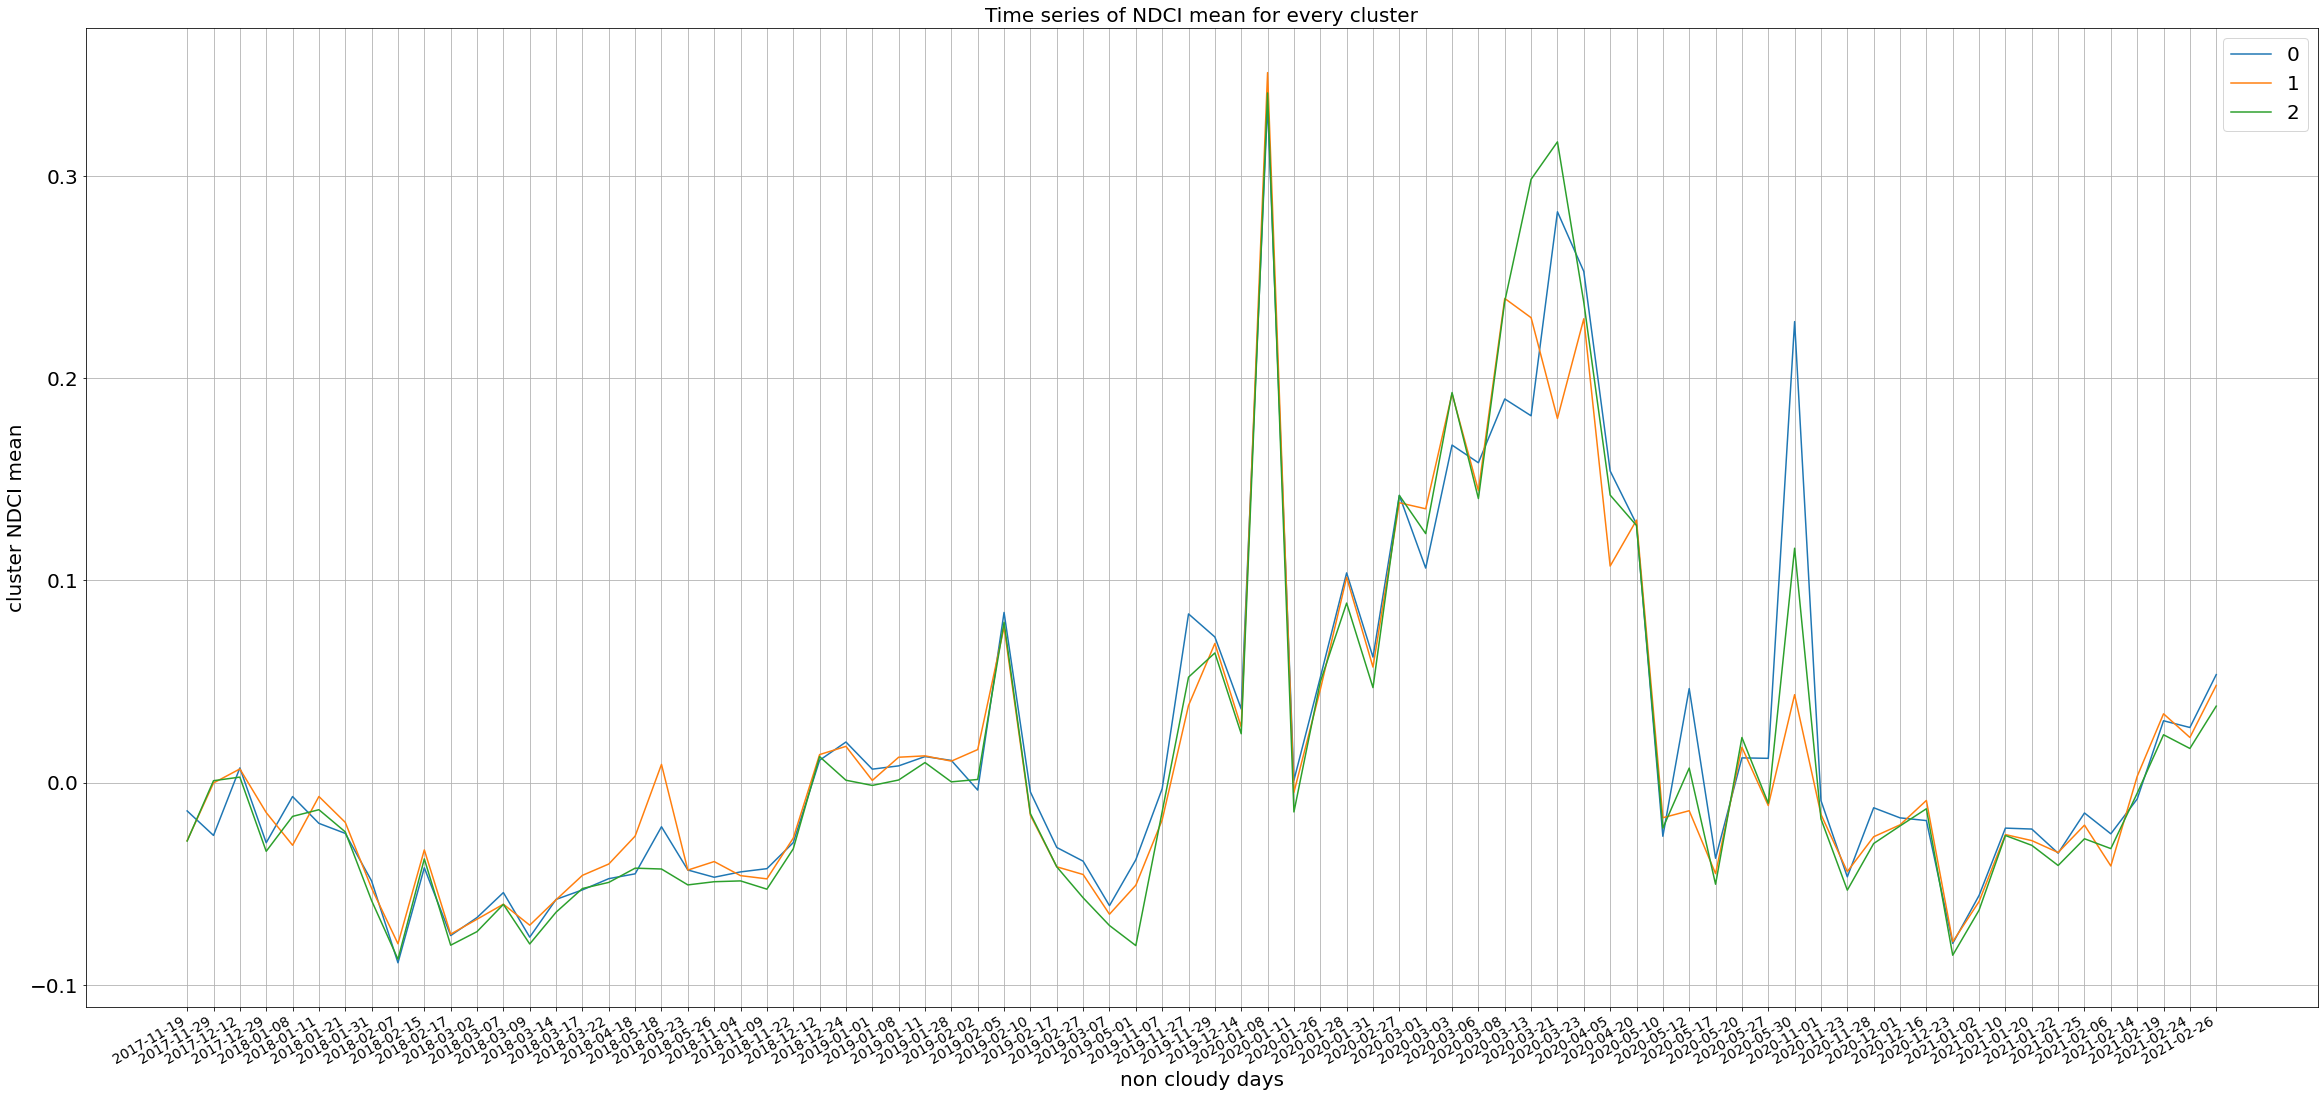

In [19]:
day_indexes = range(1, len(results)+1)
fig = plt.figure(figsize=(40,20))
for label in results_df["cluster"].unique():
    #label_means = [d[label]["mean"] for d in results]
    ndci_means = results_df[results_df["cluster"] == label]["mean_ndci"].tolist()
    dates = results_df[results_df["cluster"] == label]["date"].values
    dates = [str(d)[0:10] for d in dates]
    #label_stds = [d[label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.plot([d["date"] for d in results], label_means, label=str(label))
    plt.plot(dates, ndci_means, label=str(label))
    #plt.plot(day_indexes, label_stds, label=str(label) + " std")
    
plt.xlabel('non cloudy days', fontsize=20)
plt.xticks(np.arange(0, len(ndci_means), 1.0), fontsize=14)
# Set the y axis label of the current axis.
plt.ylabel('cluster NDCI mean', fontsize=20)
plt.yticks(fontsize=20)
# Set a title of the current axes.
plt.title('Time series of NDCI mean for every cluster', fontsize=20)
# put date in angle to read better
fig.autofmt_xdate()
# show a legend on the plot
plt.legend(fontsize=20)
plt.grid()
# save figure
#plt.savefig("test3.png", dpi=100, bbox_inches='tight')
# Display a figure.
plt.show()
#plt.close(fig)

### Operations with satellite data and empiric data

/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


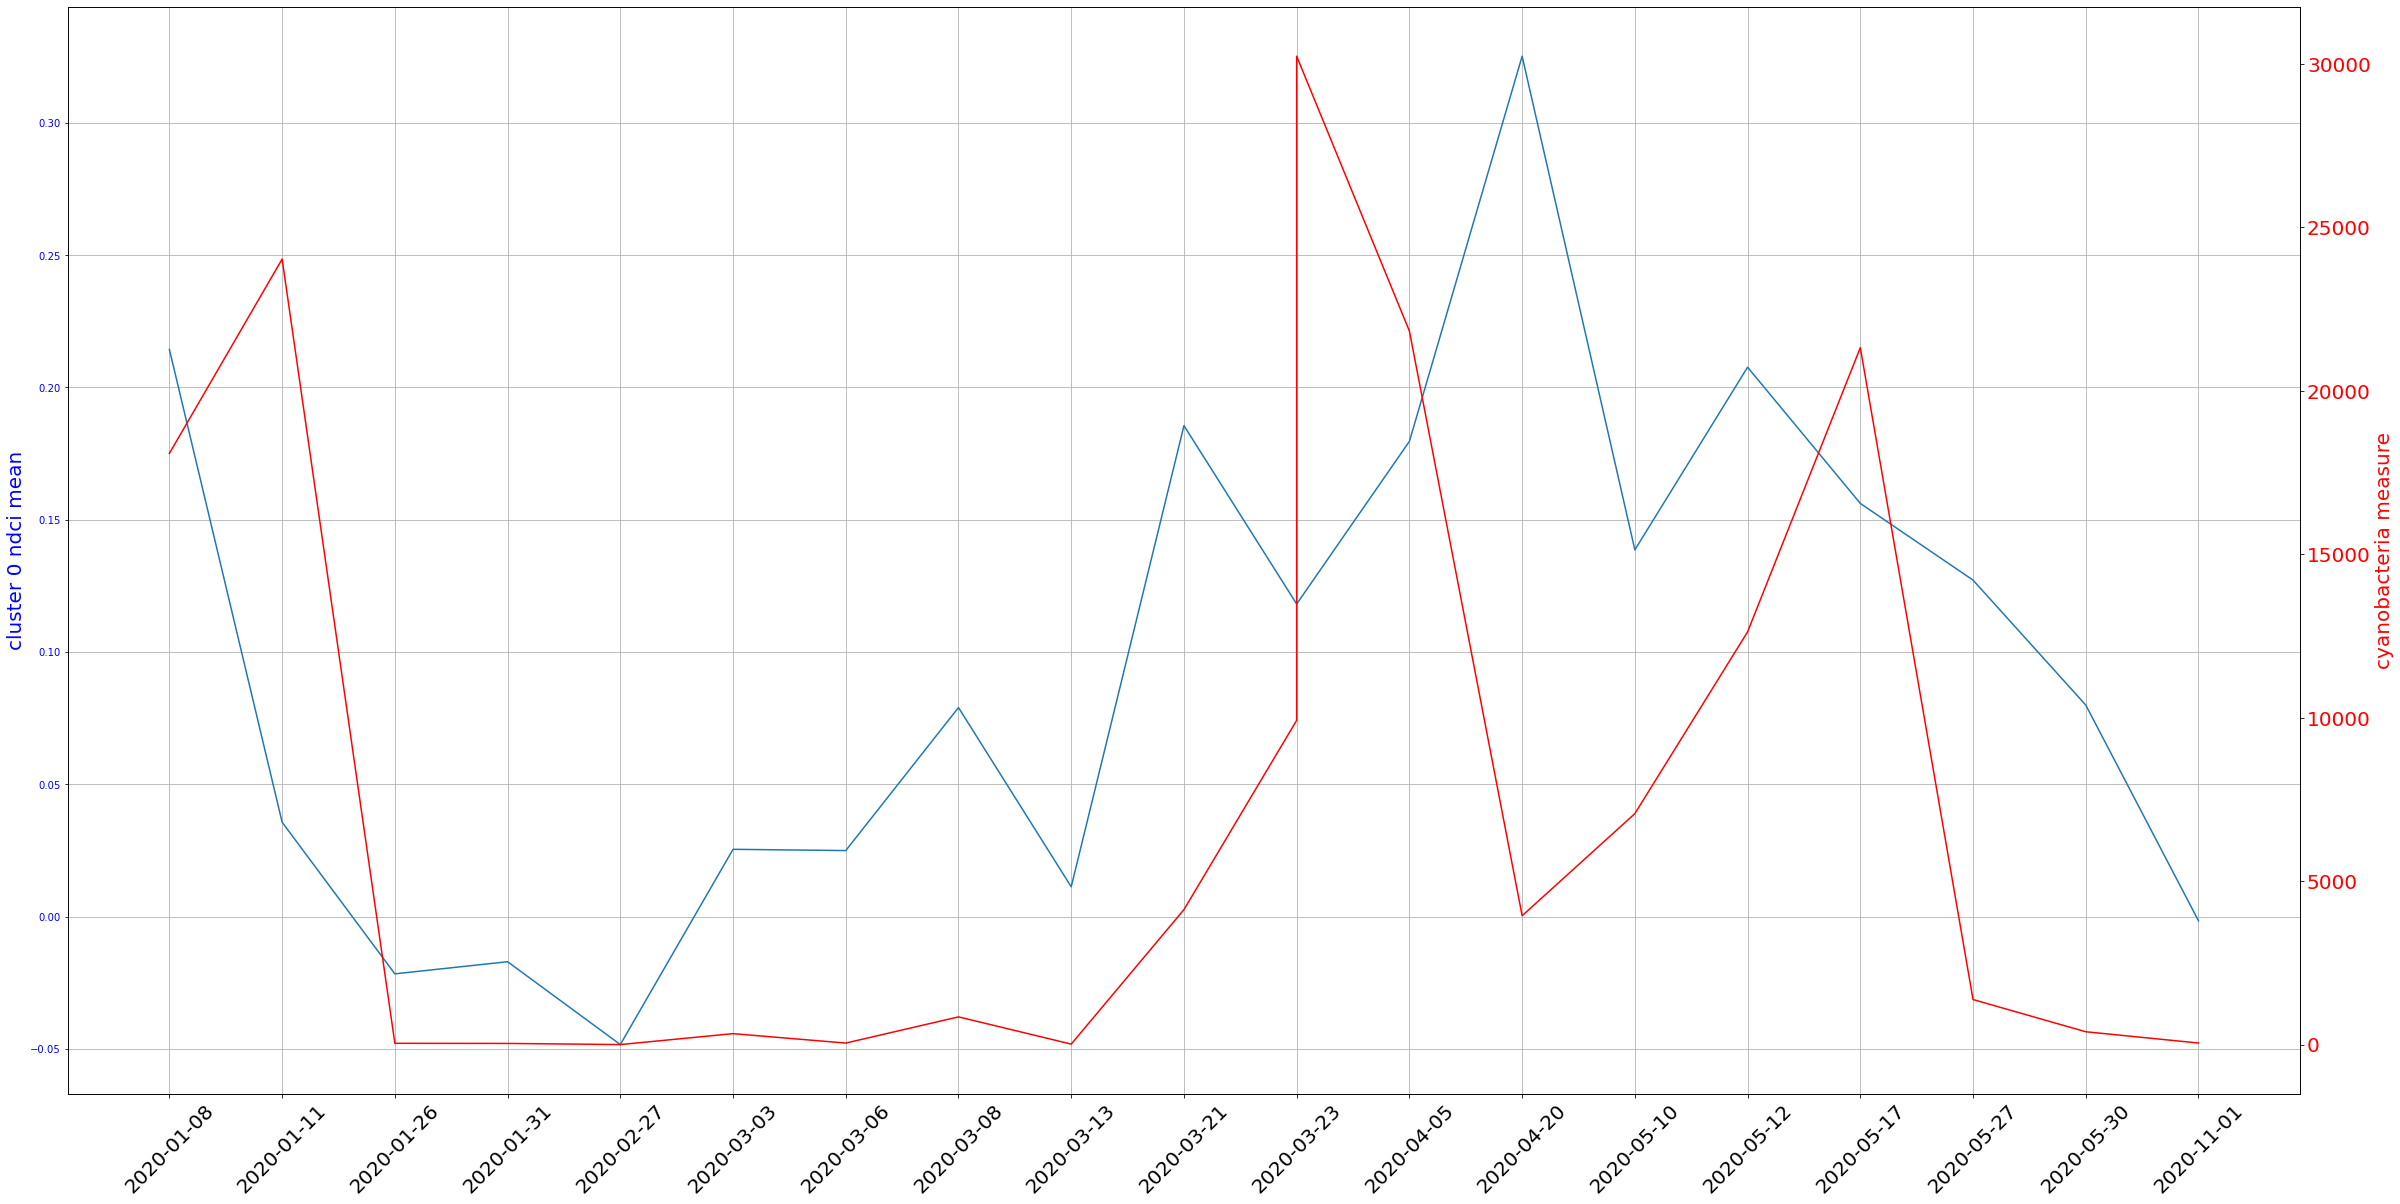

(0.40945526134762145, 0.07300750719127111)


/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


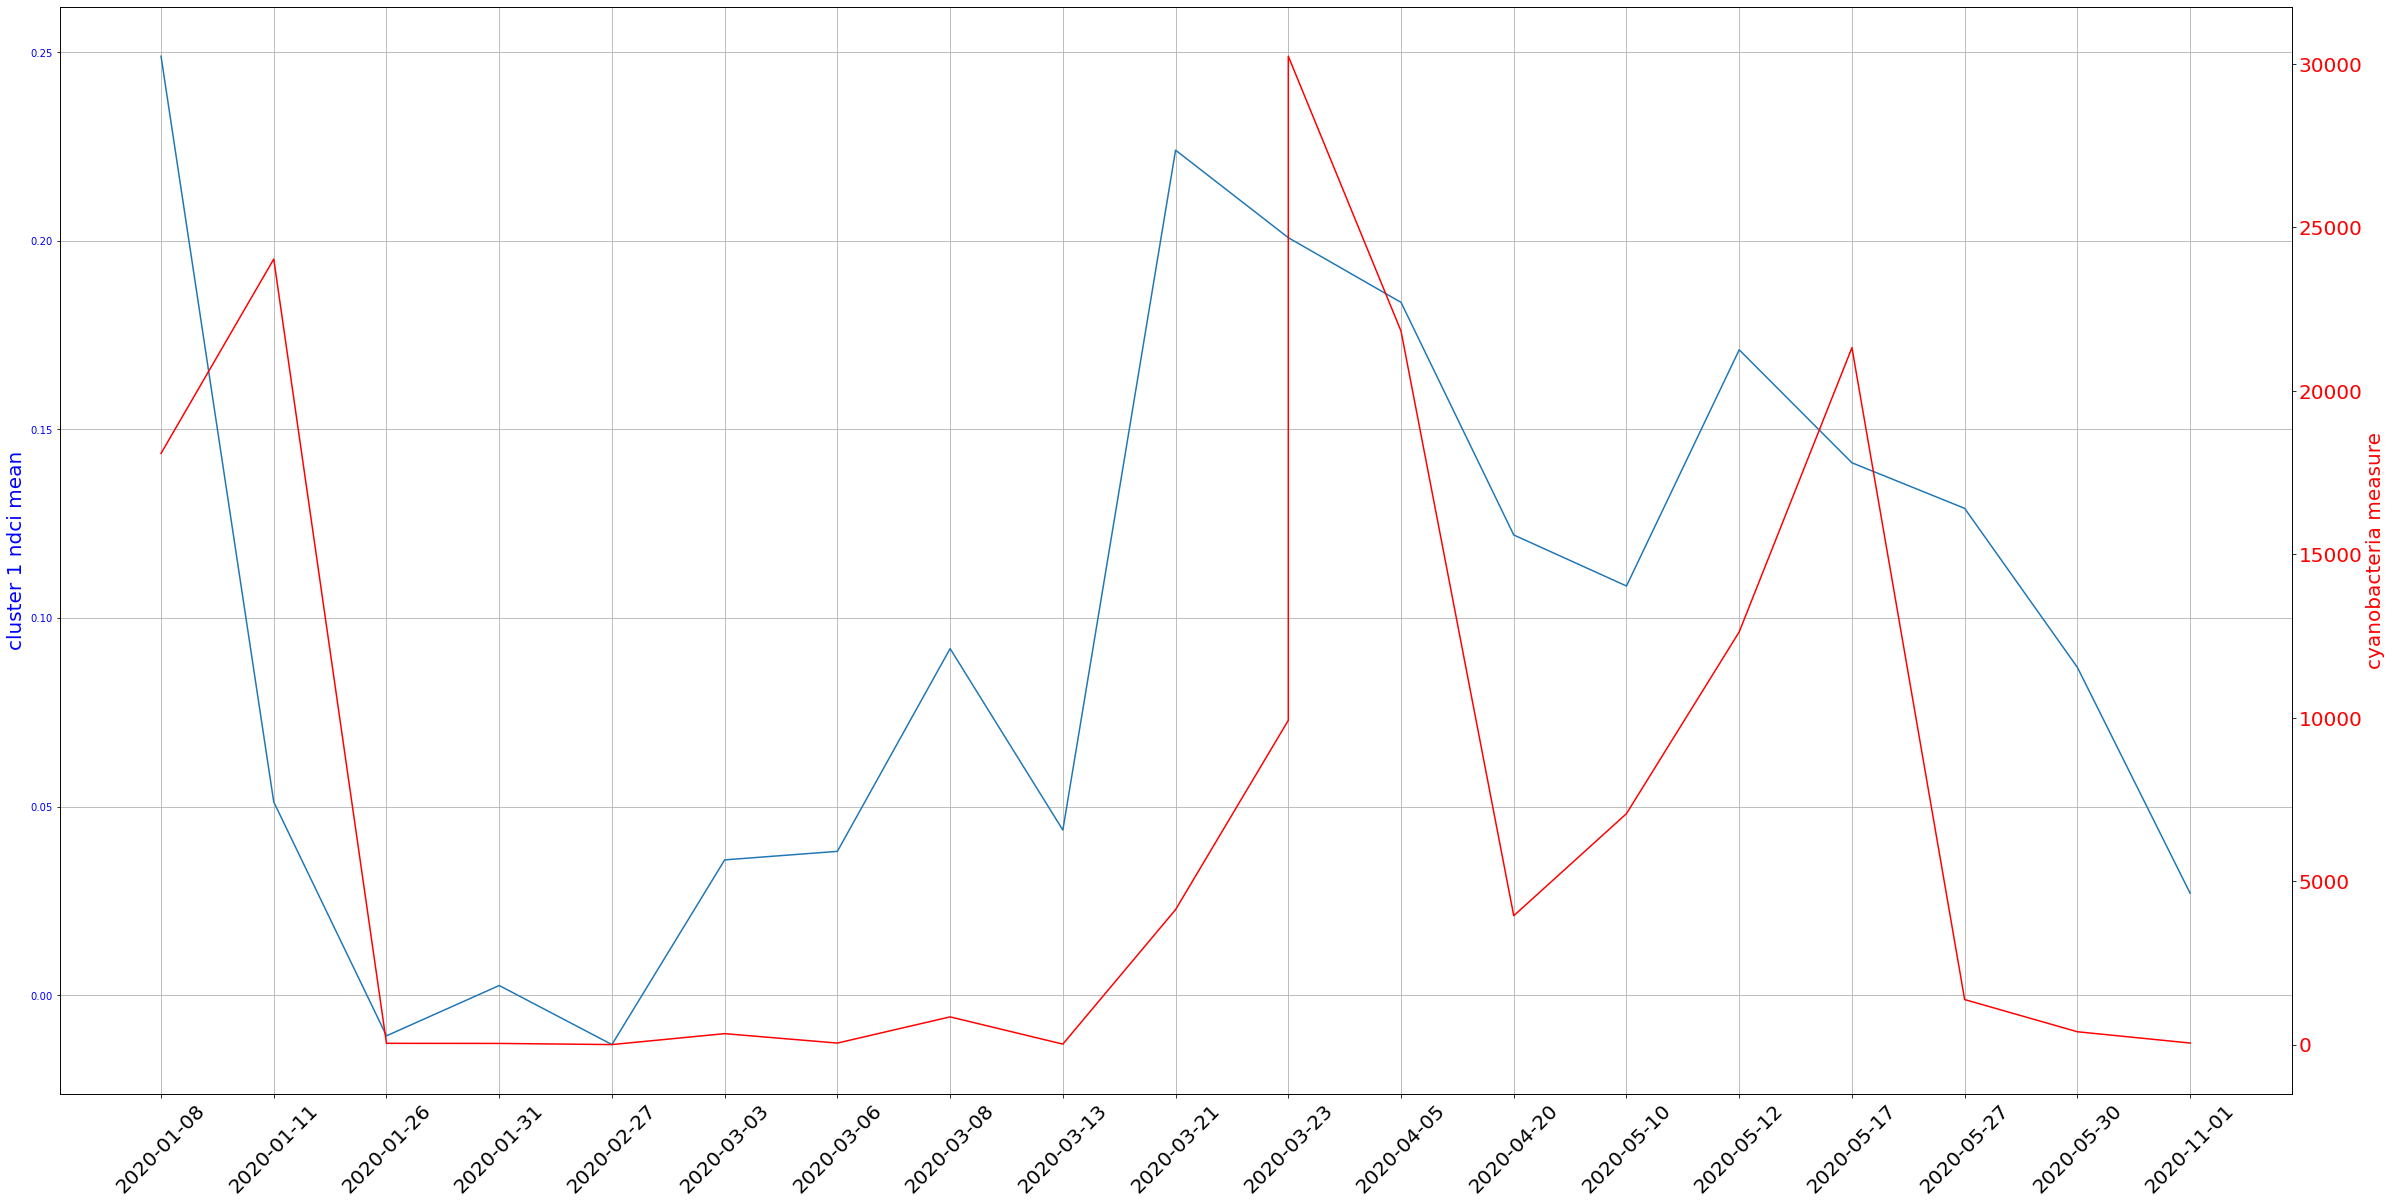

(0.5963950995834739, 0.005510962331019107)


/home/enzo_tng/anaconda3/envs/cyano_venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


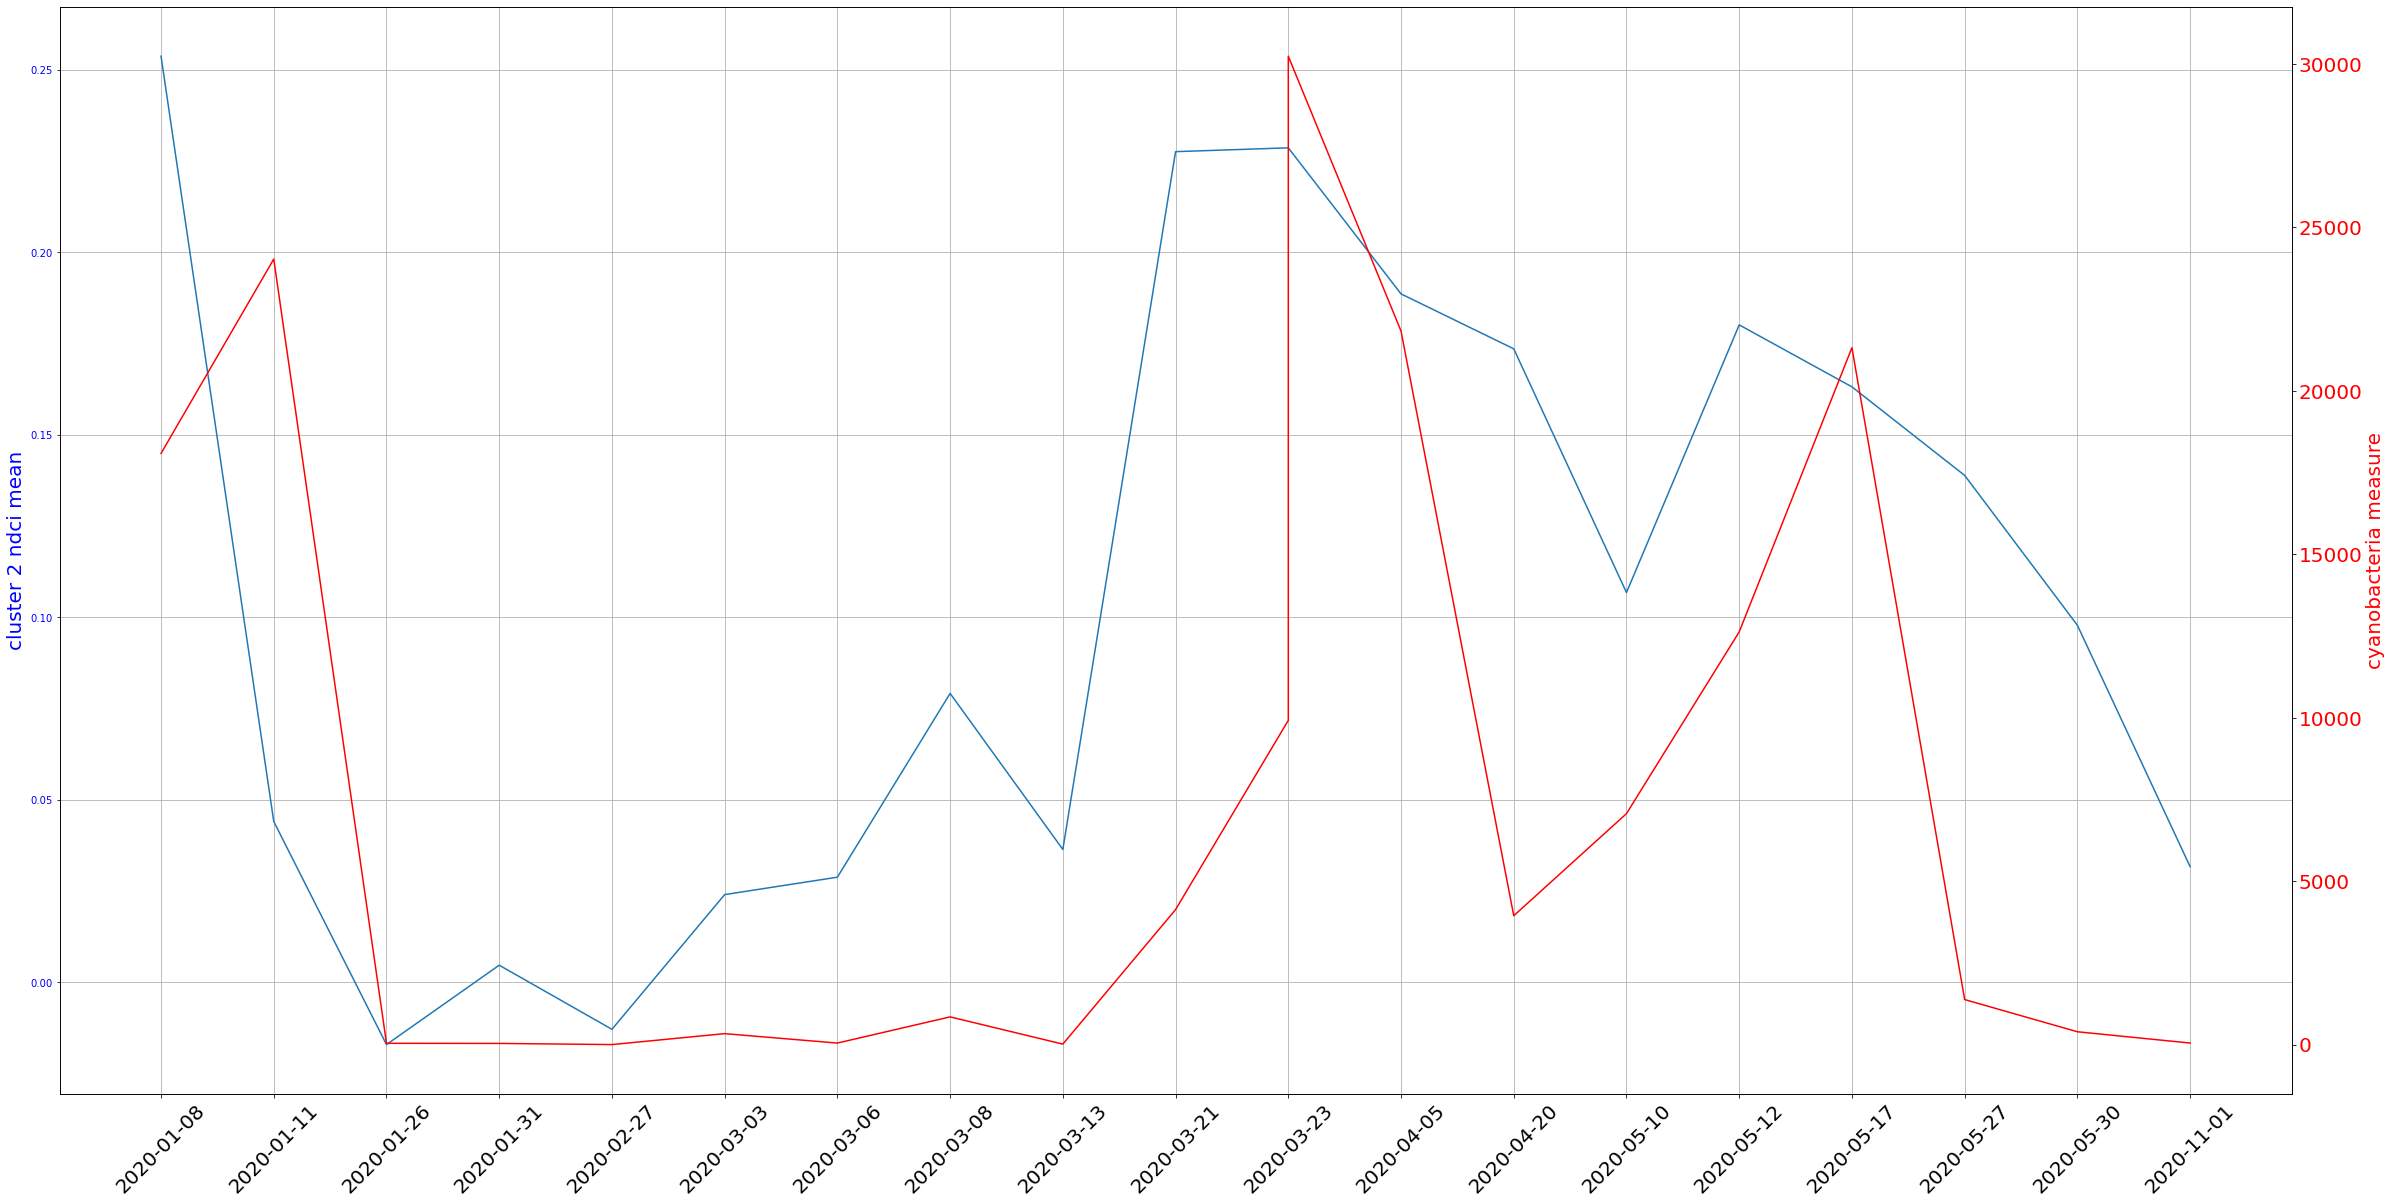

(0.5958220052054223, 0.005568030157322088)


In [127]:
from scipy.stats.stats import pearsonr

for i in [0,1,2]:
    cluster_df = results_df[results_df["cluster"] == i]

    common_data_df = cluster_df.merge(agua_data, left_on='date', right_on='date')
    dates = common_data_df["date"].values
    dates = [str(d)[0:10] for d in dates]
    cyanobacteria = common_data_df["cyanobacteria"].values
    ndci_means = common_data_df["mean_ndci"].values
    fig = plt.figure(figsize=(40,20))
    plt.grid()
    ax1 = fig.add_subplot(111)
    ax1.plot(dates, ndci_means)
    ax1.set_ylabel('cluster ' + str(i) + ' ndci mean', fontsize=20, color="b")
    plt.xticks(fontsize=20, rotation=45)
    ax2 = ax1.twinx()
    ax2.plot(dates, cyanobacteria, 'r-')
    ax2.set_ylabel('cyanobacteria measure', color='r', fontsize=20)
    for tl in ax2.get_yticklabels():
        tl.set_color('r')
    for tl in ax1.get_yticklabels():
        tl.set_color('b')
    plt.yticks(fontsize=20)
    plt.show()

    print(pearsonr(ndci_means, cyanobacteria))

### Time series of every cluster mean and std

No handles with labels found to put in legend.


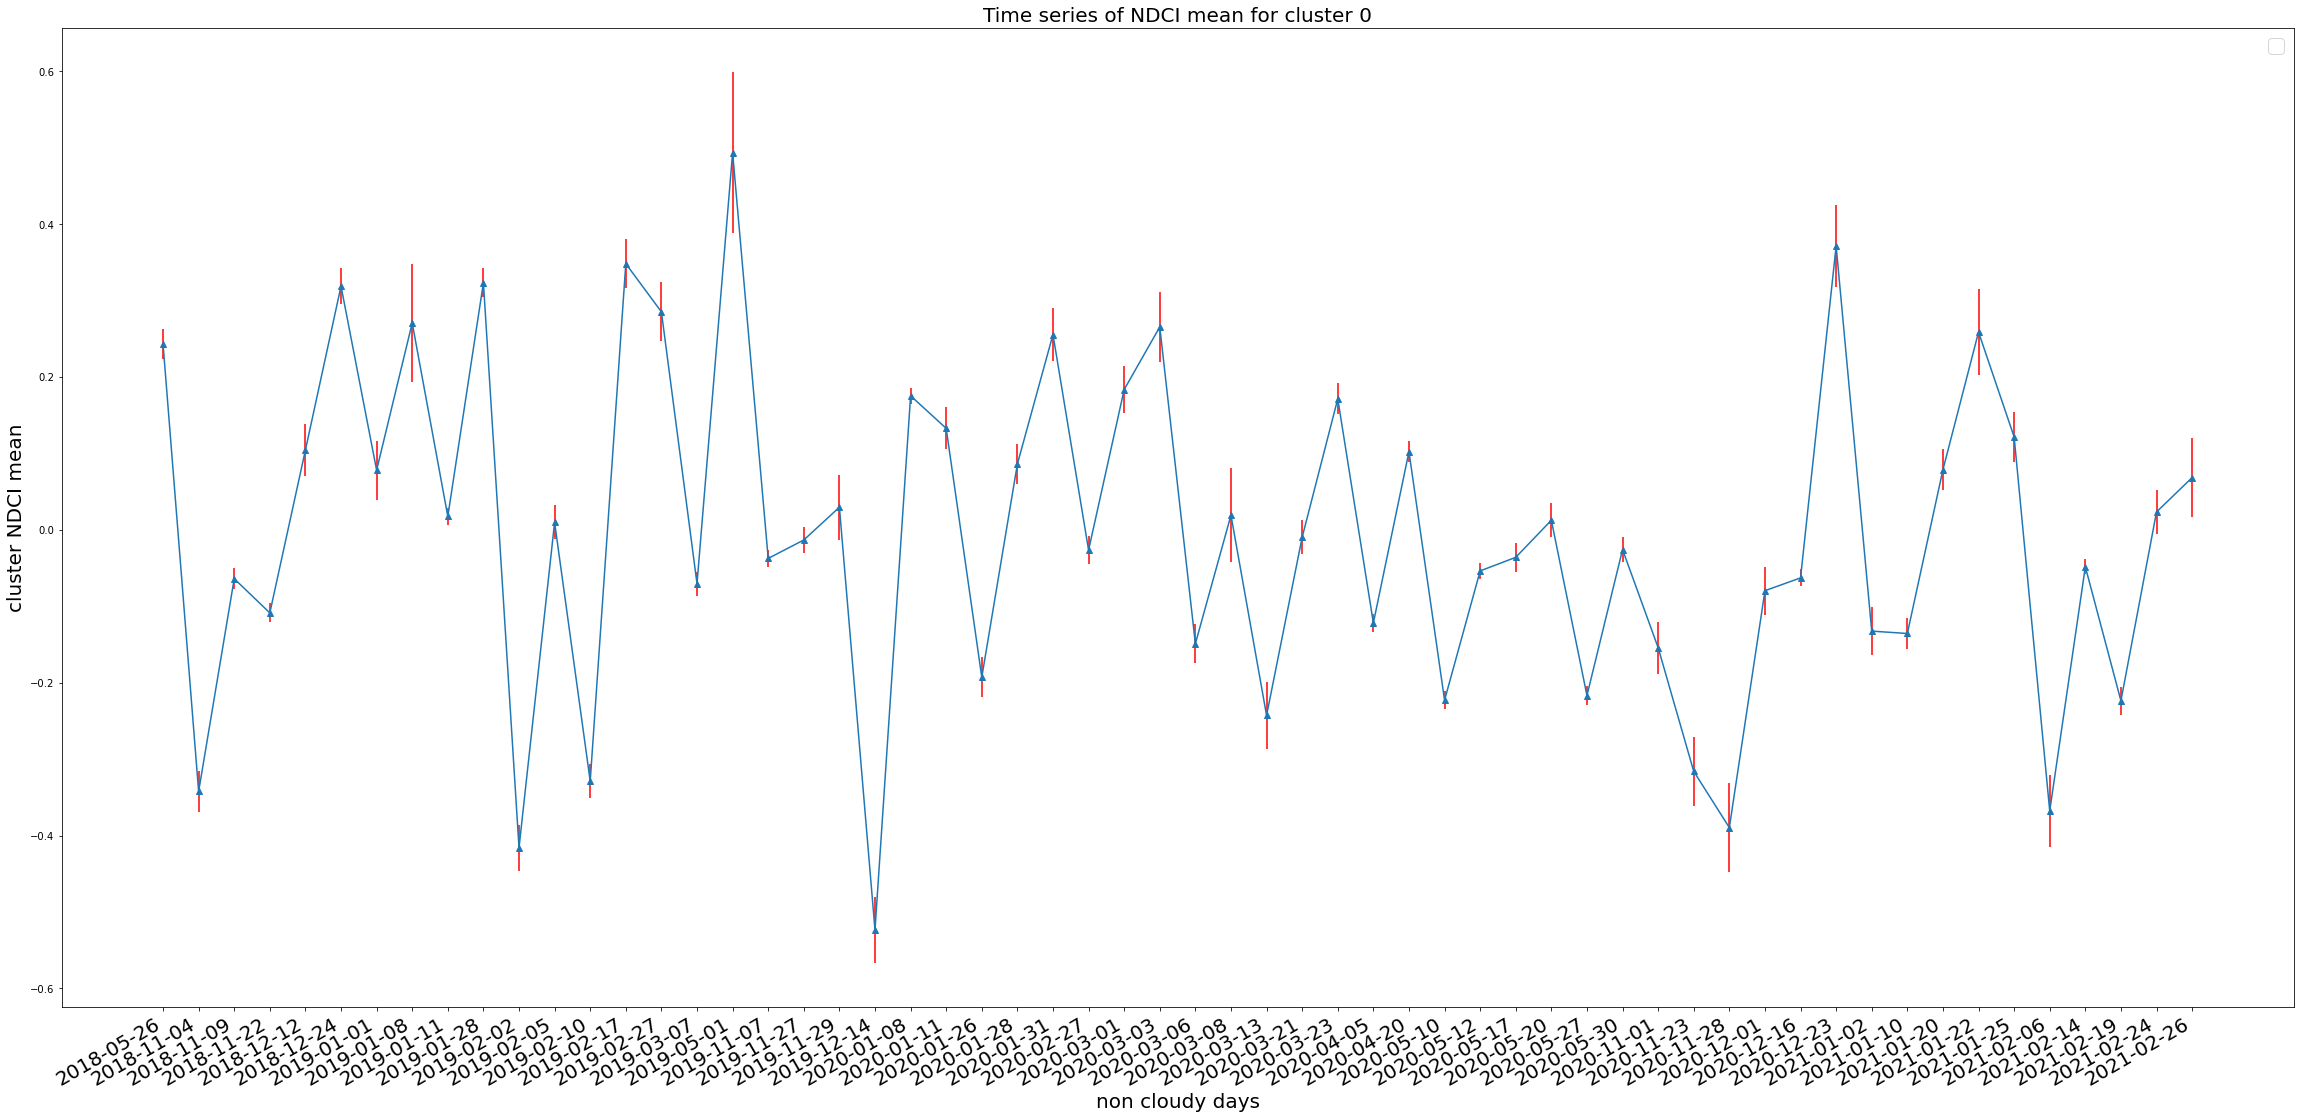

No handles with labels found to put in legend.


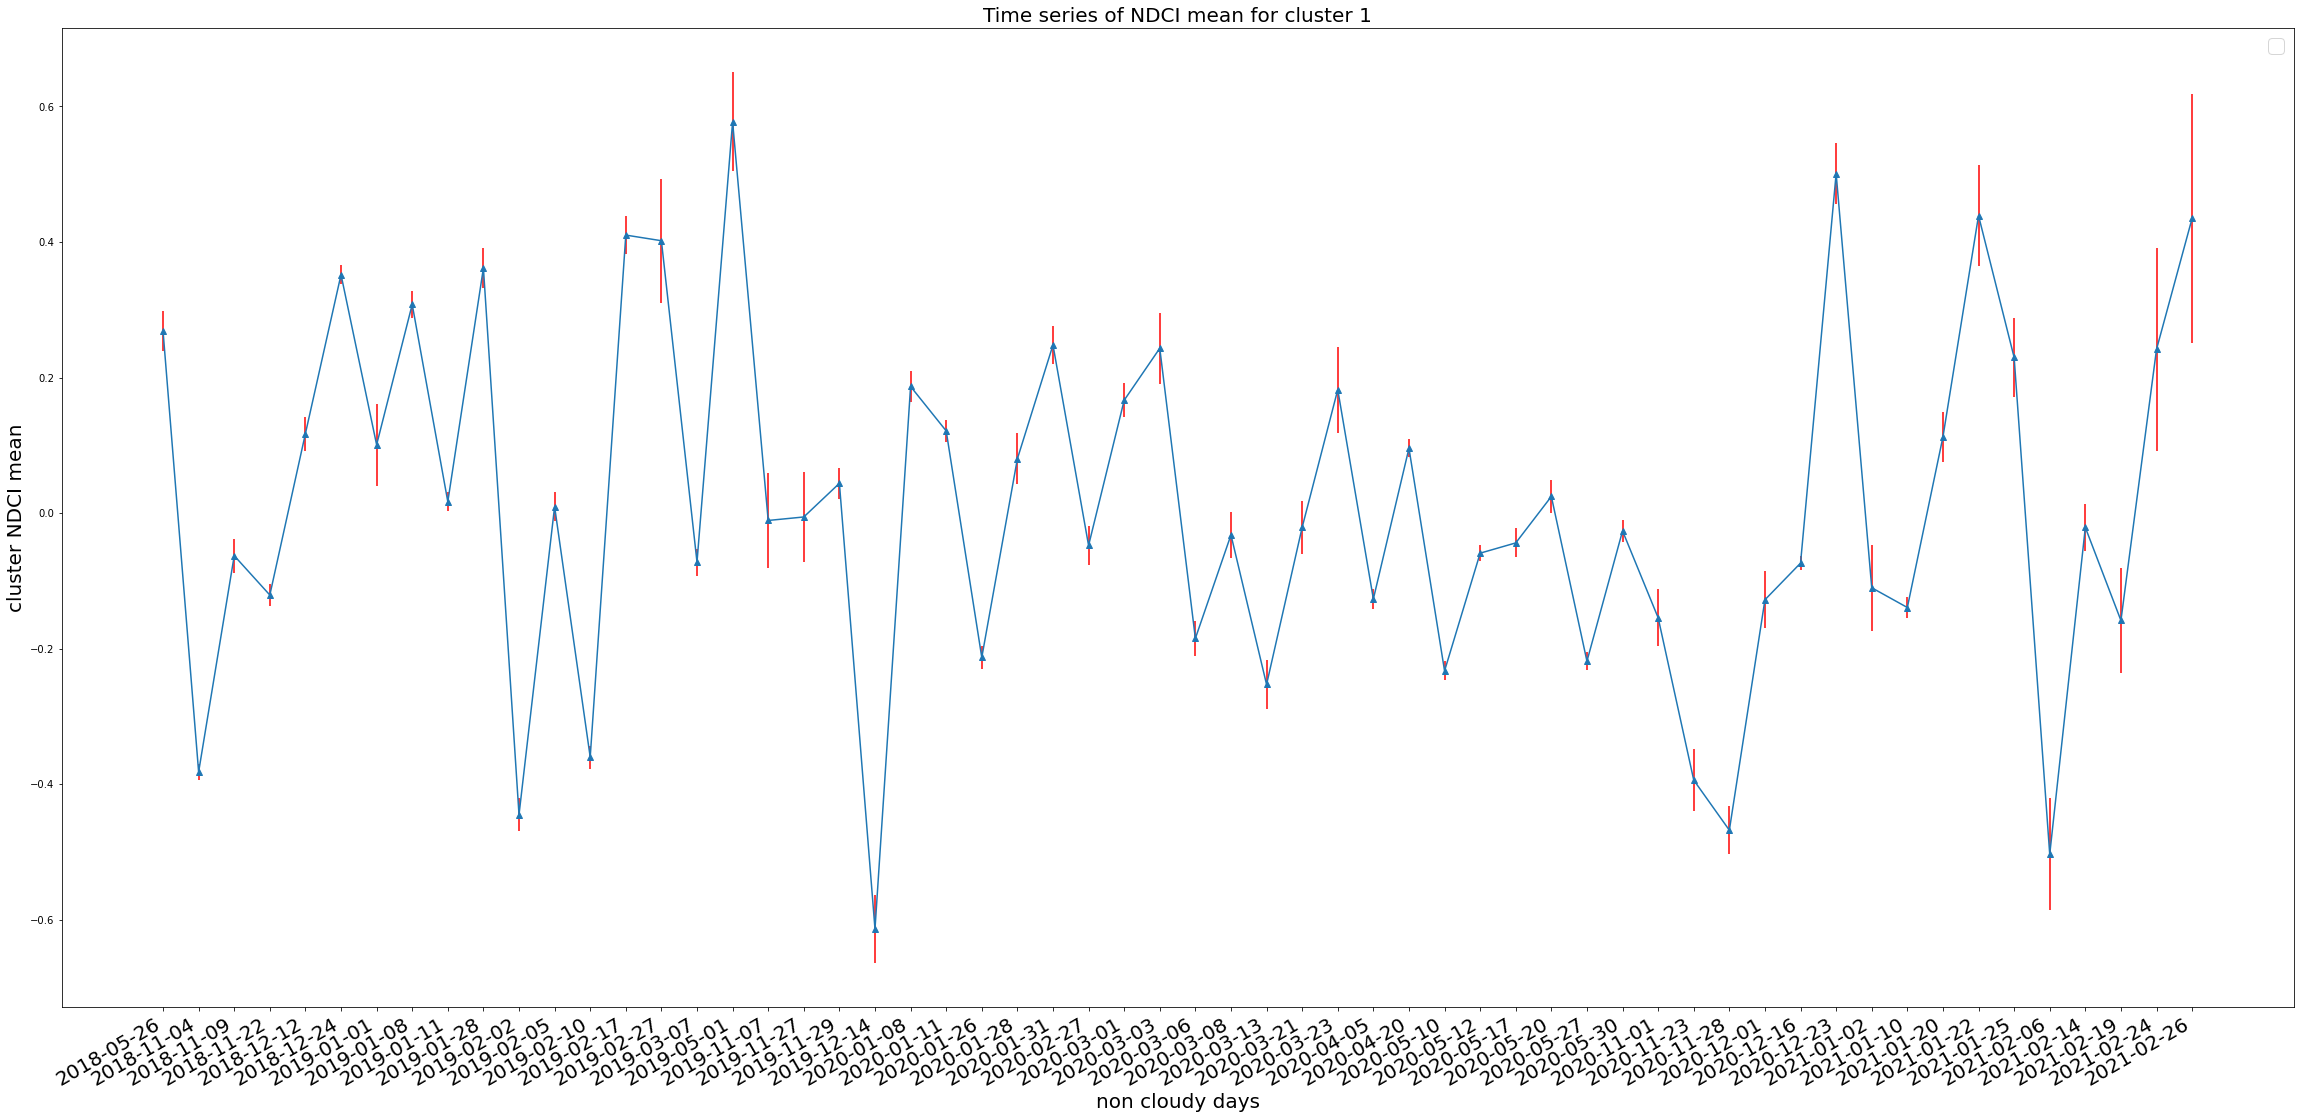

No handles with labels found to put in legend.


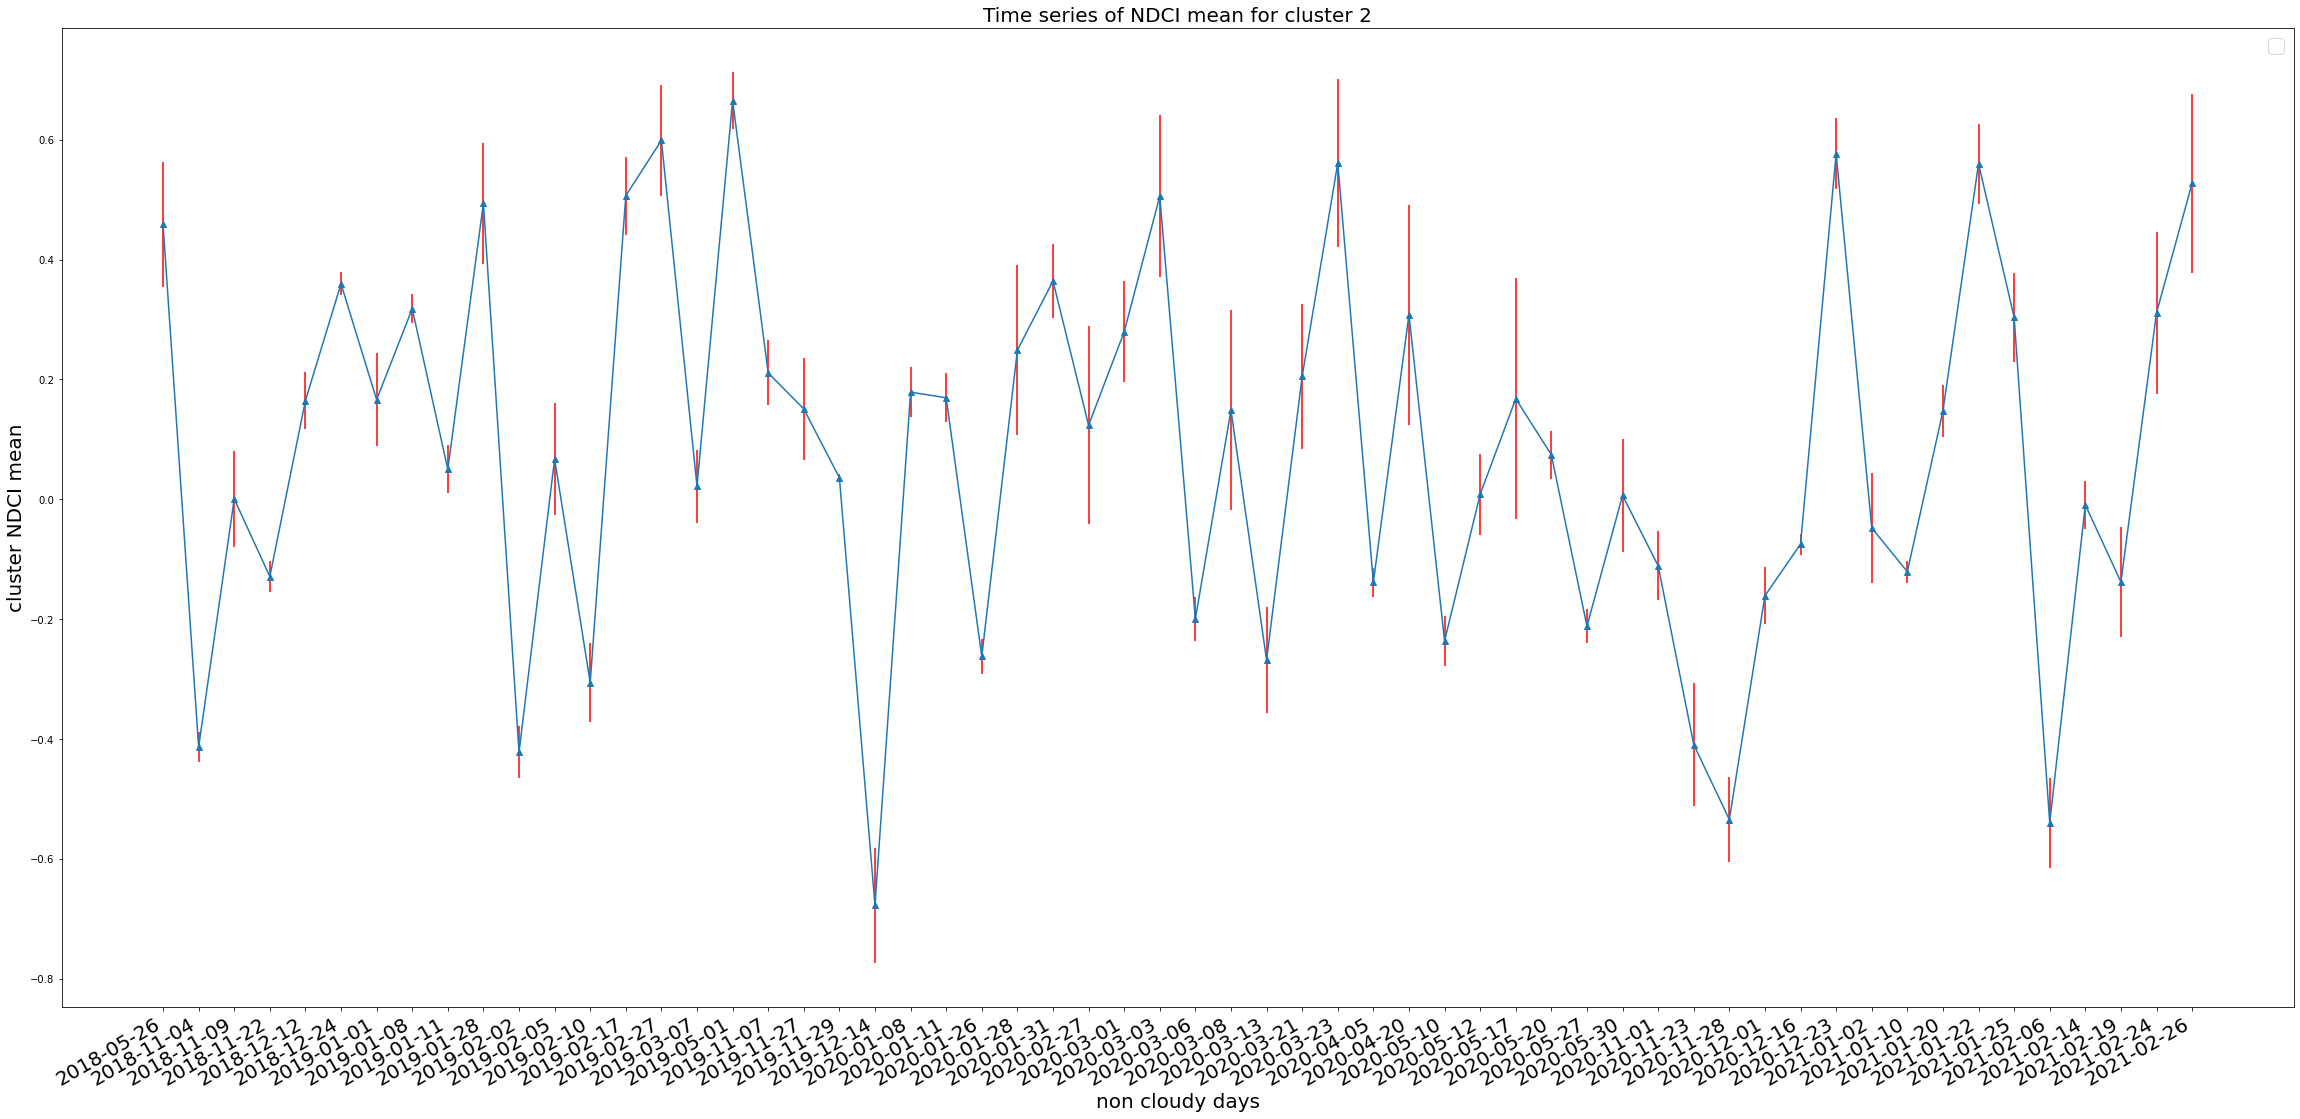

In [30]:
import matplotlib.pyplot as plt

for cluster_label in unique_labels:
    fig = plt.figure(figsize=(40,20))
    label_means = [d[cluster_label]["mean"] for d in results]
    label_stds = [d[cluster_label]["std"] for d in results]
    #plt.plot(day_indexes, label_means, label=str(label) + " mean")
    #plt.errorbar([d["date"] for d in results], label_means, label_stds, linestyle='None', marker='^')
    plt.errorbar([d["date"] for d in results], label_means, label_stds, marker='^', ecolor="red")
    #plt.plot([d["date"] for d in results], label_means, label=str(cluster_label))
    #plt.plot(day_indexes, label_stds, label=str(cluster_label) + " std")

    plt.xlabel('non cloudy days', fontsize=20)
    plt.xticks(np.arange(0, len(results), 1.0), fontsize=20)
    # Set the y axis label of the current axis.
    plt.ylabel('cluster NDCI mean', fontsize=20)
    # Set a title of the current axes.
    plt.title('Time series of NDCI mean for cluster ' + str(cluster_label), fontsize=20)
    # put date in angle to read better
    fig.autofmt_xdate()
    # show a legend on the plot
    plt.legend(fontsize=20)
    # save figure
    #plt.savefig("test3.png", dpi=100, bbox_inches='tight')
    # Display a figure.
    plt.show()
    #plt.close(fig)

### Visualize rgb from day in particular

2021-02-26


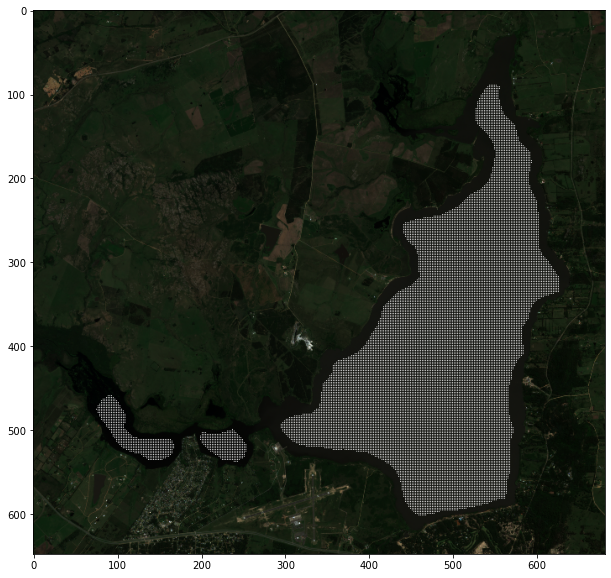

In [21]:
#DATE = "2021-01-25"
DATE = results[-1]["date"]
print(DATE)

day_data = DayData(os.path.join(settings.data_path, DATE, "acolite_output"))
fig = plt.figure(figsize=(20,10))
#plt.imshow(day_data.rgb)
plt.imshow(mask.display_mask_img(day_data.rgb))
plt.show()

### Compress directorys with results

In [ ]:
#!tar -zcvf K-means.tar.gz K-means
#!tar -zcvf Agglomerative.tar.gz Agglomerative_clustering
#!tar -zcvf Spectral.tar.gz Spectral